# Machine Learning Engineer Nanodegree
## Investment and Trading Capstone Project
## Project: Build a Stock Price Indicator
----
## Exploring the Data
Load necessary Python libraries and the price data. Note that the column from this dataset will be calculated to our target label (whether the next daily price" ups, flats or downs) and the features of other days. All other columns are features for near days. This project import the python module [`googlefinance.client`](https://pypi.python.org/pypi/googlefinance.client) instead of [`yahoo-finance`](http://pypi.python.org/pypi/yahoo-finance) [which is being discontinued](https://yahoo.sdx.socialdynamx.com/portal/conversation/19248672) although it is planned in the proposal. Because the trading days one year is a little few for machine learning, we will try to use ten years. This Notebook is inherited from the [Udacity project template: Finding Donors for CharityML](https://github.com/udacity/machine-learning/blob/master/projects/finding_donors/finding_donors.ipynb) and [Creating Customer Segments](https://github.com/udacity/machine-learning/blob/master/projects/customer_segments/customer_segments.ipynb).

In [1]:
import numpy                as     np
import pandas               as     pd
import seaborn              as     sns
import matplotlib.pyplot    as     plt
import matplotlib.dates     as     dates
from   datetime             import date, timedelta
from   time                 import time
from   IPython.display      import display         # Allows the use of display() for DataFrames
from   collections          import OrderedDict

# Pretty display for notebooks
%matplotlib inline

# display_En   = True # Enable/Disable unnecessary complex figures to speed up the data flow

In [2]:
random_state =  7
data_p       = '7Y'                # Years, data_period to get data from current date
Page_size    = 17                  # inch, for figure size
date_split   = date(2018,   1,  1) # Split train/test data by the date
day          = timedelta(days = 1)
class_name   = lambda c: c.__class__.__name__
percent      = '{:6.2f}%'
R            = '#dd4b39'           # Google Red
G            = '#3cba54'           # Google Green
B            = '#4885ed'           # Google Blue
Y            = '#f4c20d'           # Google Yellow

def     concat        (df,      keys = None): return pd.concat( df, axis = 1, keys = keys)
def     concat_idx    (df, idx, keys = None): return    concat([df[i] for i in idx], keys)
def     concat_display(df, idx, keys = None , n = 5, head = False):
    d = concat_idx    (df, idx, keys = keys)
    display(d.head(n = n) if head else d.tail(n = n))
    return  d

In [3]:
try:
    from   googlefinance.client import get_price_data, get_prices_data #, get_prices_time_data
    
    # Load daily prices of the S&P 500
    data = get_price_data({
       'x': 'INDEXSP', # Stock exchange symbol (S&P 500: 'INDEXSP', Dow Jones: 'INDEXDJX', NYSE COMPOSITE: 'INDEXNYSEGIS'  )
       'q': '.INX'   , # Stock symbol          (S&P 500: '.INX'   , Dow Jones: '.DJI'    , NYSE COMPOSITE: 'NYA', 'AAPL'...)
       'i': '86400'  , # Interval seconds      ('86400' = 1 day  intervals)
       'p': data_p     # Period                (   '1Y' = 1 year period   )
    })                 # get price data        (return pandas dataframe)
    # Success - Display the first record
    display(data.tail(n = 1))
    
    # Comparing to get_price_data, get_prices_data focuses on daily data (avoid confusion although the same data) and flexibility
    data = get_prices_data([{
       'x': 'INDEXSP', # Stock exchange symbol (S&P 500: 'INDEXSP', Dow Jones: 'INDEXDJX', NYSE COMPOSITE: 'INDEXNYSEGIS'  )
       'q': '.INX'   , # Stock symbol          (S&P 500: '.INX'   , Dow Jones: '.DJI'    , NYSE COMPOSITE: 'NYA', 'AAPL'...)
    }],     data_p   ) # get price data        (return pandas dataframe)
    # Success - Display the first record
    display(data.tail(n = 1))
    
    data     .  to_csv  ('SP.csv.txt')                                    # Save the got data (10 years: 125 KB)
except:
    data = pd.read_csv  ('SP.csv.txt', index_col = 0, parse_dates = True) # Load the got data (when googlefinance fails)

,Open,High,Low,Close,Volume
2018-04-12 04:00:00,2643.89,2661.43,2639.25,2642.19,1788526146


,.INX_Open,.INX_High,.INX_Low,.INX_Close,.INX_Volume
2018-04-12,2643.89,2661.43,2639.25,2642.19,1788526146


### Implementation: Data Cleaning
The data with abnormal 0 needs to be cleaned

In [4]:
data  = data.rename(columns = lambda c: c.split('_')[-1]) # Clean column names
display(data.describe())                                  # Check data

,Open,High,Low,Close,Volume
count,1760.000000,1760.000000,1760.000000,1760.000000,1.760000e+03
mean,1886.083443,1894.825432,1876.789693,1887.943057,8.633736e+08
std,422.901076,423.084189,422.575943,420.609912,6.579514e+08
min,0.000000,0.000000,0.000000,1099.230000,0.000000e+00
25%,1466.207500,1472.237500,1460.782500,1471.707500,4.946272e+08
50%,1954.640000,1963.975000,1942.065000,1954.045000,5.853196e+08
75%,2126.812500,2132.317500,2119.882500,2126.535000,8.540674e+08
max,2867.230000,2872.870000,2851.480000,2872.870000,4.024144e+09


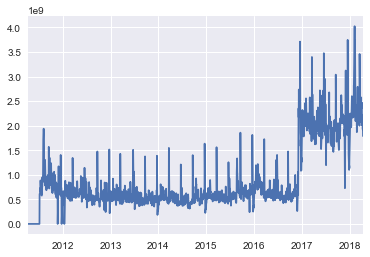

In [5]:
data['Volume'].plot();                                    # Check 0 Volumes

In [6]:
# Discard days with 0 Volumn & check again
Day_Volume  = data[data['Volume'] == 0].index[-1] + day
print 'Cleaned data with Volume start from: ' + str(Day_Volume)
data_Volume = data[Day_Volume:]
display(data_Volume.describe())

Cleaned data with Volume start from: 2012-01-15


,Open,High,Low,Close,Volume
count,1568.000000,1568.000000,1568.000000,1568.000000,1.568000e+03
mean,1963.354362,1971.892978,1954.315427,1965.464362,9.012604e+08
std,381.391650,382.090548,380.438211,378.075692,6.693925e+08
min,0.000000,0.000000,0.000000,1278.040000,1.839316e+08
25%,1673.087500,1680.045000,1662.222500,1675.845000,4.982246e+08
50%,2003.320000,2016.820000,1992.090000,2002.305000,5.791136e+08
75%,2164.530000,2170.125000,2156.187500,2164.300000,8.655811e+08
max,2867.230000,2872.870000,2851.480000,2872.870000,4.024144e+09


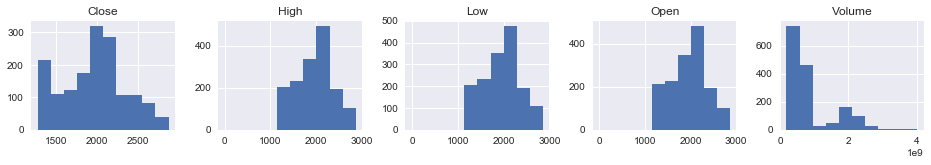

In [7]:
data_Volume.hist(figsize = (16, 2), layout = (1, 5));     # Check distribution

In [8]:
for c in ['Open', 'High', 'Low']:
    display(data_Volume[data_Volume[ c    ] < 1000]) # Check prices < 1000 (the strange gap in 'Open', 'High', and 'Low')

,Open,High,Low,Close,Volume
2017-08-01,0.0,0.0,0.0,2470.3,2189633778


,Open,High,Low,Close,Volume
2017-08-01,0.0,0.0,0.0,2470.3,2189633778


,Open,High,Low,Close,Volume
2017-08-01,0.0,0.0,0.0,2470.3,2189633778


,Open,High,Low,Close,Volume
count,1567.000000,1567.000000,1567.000000,1567.000000,1.567000e+03
mean,1964.607301,1973.151366,1955.562597,1965.142195,9.004382e+08
std,378.271560,378.948333,377.339606,377.981028,6.688138e+08
min,1277.820000,1282.550000,1266.740000,1278.040000,1.839316e+08
25%,1674.790000,1681.960000,1663.095000,1675.570000,4.981828e+08
50%,2003.570000,2016.890000,1992.440000,2002.280000,5.786320e+08
75%,2164.730000,2170.150000,2156.295000,2164.225000,8.640995e+08
max,2867.230000,2872.870000,2851.480000,2872.870000,4.024144e+09


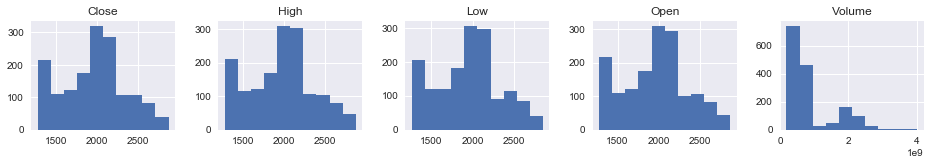

In [9]:
data_Volume_Price     = data_Volume[
                        data_Volume['Open'] > 1000]               # Discard the abnormal day
data_Volume_Price     . hist(figsize = (16, 2), layout = (1, 5));
display               ( data_Volume_Price.describe())
data_cln              = data_Volume_Price                         # Cleaned data

### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many days fit into either group, and will tell us about the percentage of these daily prices uping or falling. In the code cell below, we will compute the basic following and additional statistics with [stockstats](https://pypi.python.org/pypi/stockstats):
- The total number of records, `'n_records'`.
- The number of the next daily prices upping, `'n_up'`.
- The number of the next daily prices downing, `'n_down'`.
- The number of the next daily prices flatting, `'n_flat'`.
- The percentage of the next daily prices upping, `'up_percent'`.

In [10]:
col_pre   =  ['Open' ,   'Close']                  # Collect previous daily data column to cancat together
col_next  =  ['Open' ,   'Close']                  # Collect next     daily data column to cancat together
d         = concat([   data_cln[     col_pre ].shift( 1).rename(columns = lambda c: c + '_pre' ),
                       data_cln])                  # d is the acronyms to cancat all data
d         = concat([d, data_cln[     col_next].shift(-1).rename(columns = lambda c: c + '_next')
                               ])[1:-1]            # Discard the 1st/last one which lacks a previous/next daily data
y_rgr     = list  ( d. columns [-len(col_next):])  # Select data column for regression y

X_vec, y_clf_vec = [], []
for                    p1,     p2 in [
   # Timeline: Open_pre > Close_pre > Open >  Close >  Open_next >  Close_next
             ('Open_pre'                   , 'Close'                           ), # Vector from Open_pre  to Close
             (           'Close_pre'       , 'Close'                           ), # Vector from Close_pre to Close
             (                       'Open', 'Close'                           ), # Vector from Open      to Close
             (                       'Open',          'Open_next'              ), # Vector from Open      to  Open_next
             (                               'Close', 'Open_next'              ), # Vector from Close     to  Open_next
             (                               'Close',              'Close_next'), # Vector from Close     to Close_next
             (                                        'Open_next', 'Close_next'), # Vector from Open_next to Close_next
             ]:
    p      = '_'.join([p1,     p2    ])
    d [p]  =  -      d[p1] + d[p2]
    if 0  <=    p.find  ('Close_next' ): # next daily data are usually for y
        y_clf_vec.append(      p      )  # Vectors for classification y
    else:
        X_vec    .append(      p      )  #

X_up, y_clf = [], []
for vec      in     X_vec + y_clf_vec  : # Index of records where the next daily prices up
    col    =          vec +     '_up'    # Merge 'flat' to 'up': Align to the 'up' of matplotlib.finance
    d[col] =  0 <=  d[vec]
    if 0  <=  col.find  ('Close_next' ): # next daily data are usually for y
        y_clf    .append(        col  )
    else:
        X_up     .append(        col  )

X_base     = list(data_cln.columns)
X_all      = X_base + X_vec + X_up     # Select data column for X
# Xy     = [c for c in d.columns if 0 <= c.find('Open_next') and c.find('Close_next') < 0  ] # X sometimes includes Open_next

Close_Close_next_flat =         0   == d.    Close_Close_next
Close_Open_next_flat  =         0   == d.     Close_Open_next

n_records             = d.shape[0]                                # Total number of records
n_up                  = sum    (       d.Close_Close_next_up    )
n_flat                = sum    (         Close_Close_next_flat  )
n_down                = sum    (0    > d.Close_Close_next       )
up_percent            = float  (n_up)/n_records*100               # Percentage of days whose price up

print '[Example Daily Close-to-Close (Close_Close_next) prices]'
print 'Total number of records: {}'               .format(n_records )
print 'Daily prices upping:     {}  ({})'         .format(n_up      , 'Close_Close_next_up, including flatting to align the "up" of matplotlib.finance')
print 'Daily prices flatting:   {}'               .format(n_flat    )
print 'Daily prices downing:    {}'               .format(n_down    )
print 'Percentage of daily prices upping: {:.2f}%'.format(up_percent)

print '\nThe flat days with the same Close prices'
display       ( d[Close_Close_next_flat | Close_Close_next_flat.shift(1)])
print '\nThe flat day  with the same Open & Close prices'
display       ( d[    d.Open           ==  d.Close                      ])
# print '\n     {} days with the same Close & Open_next prices'.format(sum(Close_Open_next_flat))
# display       ( d[ Close_Open_next_flat |  Close_Open_next_flat.shift(1)].head(n = 2))

[Example Daily Close-to-Close (Close_Close_next) prices]
Total number of records: 1565
Daily prices upping:     846  (Close_Close_next_up, including flatting to align the "up" of matplotlib.finance)
Daily prices flatting:   1
Daily prices downing:    719
Percentage of daily prices upping: 54.06%

The flat days with the same Close prices


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Close_Open_next,Close_Close_next,Open_next_Close_next,Open_pre_Close_up,Close_pre_Close_up,Open_Close_up,Open_Open_next_up,Close_Open_next_up,Close_Close_next_up,Open_next_Close_next_up
2017-01-10,2271.14,2276.98,2273.59,2275.49,2268.90,2268.9,1914652521,2269.72,2268.90,-2.24,...,0.82,0.00,-0.82,False,False,False,False,True,True,False
2017-01-11,2273.59,2268.90,2269.72,2279.27,2265.27,2268.9,2138024556,2268.60,2275.32,-4.69,...,-0.30,6.42,6.72,False,True,False,False,False,True,True



The flat day  with the same Open & Close prices


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Close_Open_next,Close_Close_next,Open_next_Close_next,Open_pre_Close_up,Close_pre_Close_up,Open_Close_up,Open_Open_next_up,Close_Open_next_up,Close_Close_next_up,Open_next_Close_next_up
2017-04-11,2356.59,2355.54,2357.16,2366.37,2351.5,2357.16,1620328913,2353.92,2353.78,0.57,...,-3.24,-3.38,-0.14,True,True,True,False,False,False,False


** Featureset Exploration **

All features are continuous

In [11]:
hdr_base =       'Base Features ~  X_base' # Headers
hdr_vec  =     'Vector Features ~  X_vec'  #
hdr_up   =         'Up Features ~  X_up'   #
hdr_stat = 'Statistics Features ~  X_stat' # will add later
X_grp    =                      [  X_base             ,  X_vec,             X_up          ]
def X_display            (d,       X_grp = X_grp      , head = 0, n = 5):
    return concat_display(d,       X_grp              ,
                                [hdr_base             ,hdr_vec          , hdr_up, hdr_stat][:len(X_grp)], head = head, n = n)
def y_display            (d,       y_clf = y_clf      ,  y_rgr = y_rgr ):
    return concat_display(d,    [  y_clf              ,  y_rgr         ],
                                [ 'y (Classification)', 'y (Regressions)'])

X_display                (d)
y_display                (d);
# display                  (d[      y_clf_vec         ].rename(columns = lambda c: ('Vectors for Classification', c)).tail())

Base Features ~  X_base                                         \
                              Open     High      Low    Close      Volume   
2018-04-05                 2584.04  2649.86  2573.61  2644.69  2220731180   
2018-04-06                 2657.36  2672.08  2649.58  2662.84  2008036352   
2018-04-07                 2645.82  2656.88  2586.27  2604.47  2187111865   
2018-04-10                 2617.18  2653.55  2610.79  2613.16  1923050595   
2018-04-11                 2638.41  2665.45  2635.78  2656.87  2132599583   

           Vector Features ~  X_vec                                            \
                     Open_pre_Close Close_pre_Close Open_Close Open_Open_next   
2018-04-05                    52.52           30.24      60.65          73.32   
2018-04-06                    78.80           18.15       5.48         -11.54   
2018-04-07                   -52.89          -58.37     -41.35         -28.64   
2018-04-10                   -32.66            8.69      -4.02          21.23   
2018-04-11                    39.69           43.71      18.46           5.48   

                           Up Features ~  X_up                     \
           Close_Open_next   Open_pre_Close_up Close_pre_Close_up   
2018-04-05           12.67                True               True   
2018-04-06          -17.02                True               True   
2018-04-07           12.71               False              False   
2018-04-10           25.25               False               True   
2018-04-11          -12.98                True               True   

                                                               
           Open_Close_up Open_Open_next_up Close_Open_next_up  
2018-04-05          True              True               True  
2018-04-06          True             False              False  
2018-04-07         False             False               True  
2018-04-10         False              True               True  
2018-04-11          True              True              False

y (Classification)                         y (Regressions)  \
           Close_Close_next_up Open_next_Close_next_up       Open_next   
2018-04-05                True                    True         2657.36   
2018-04-06               False                   False         2645.82   
2018-04-07                True                   False         2617.18   
2018-04-10                True                    True         2638.41   
2018-04-11               False                   False         2643.89   

                       
           Close_next  
2018-04-05    2662.84  
2018-04-06    2604.47  
2018-04-07    2613.16  
2018-04-10    2656.87  
2018-04-11    2642.19

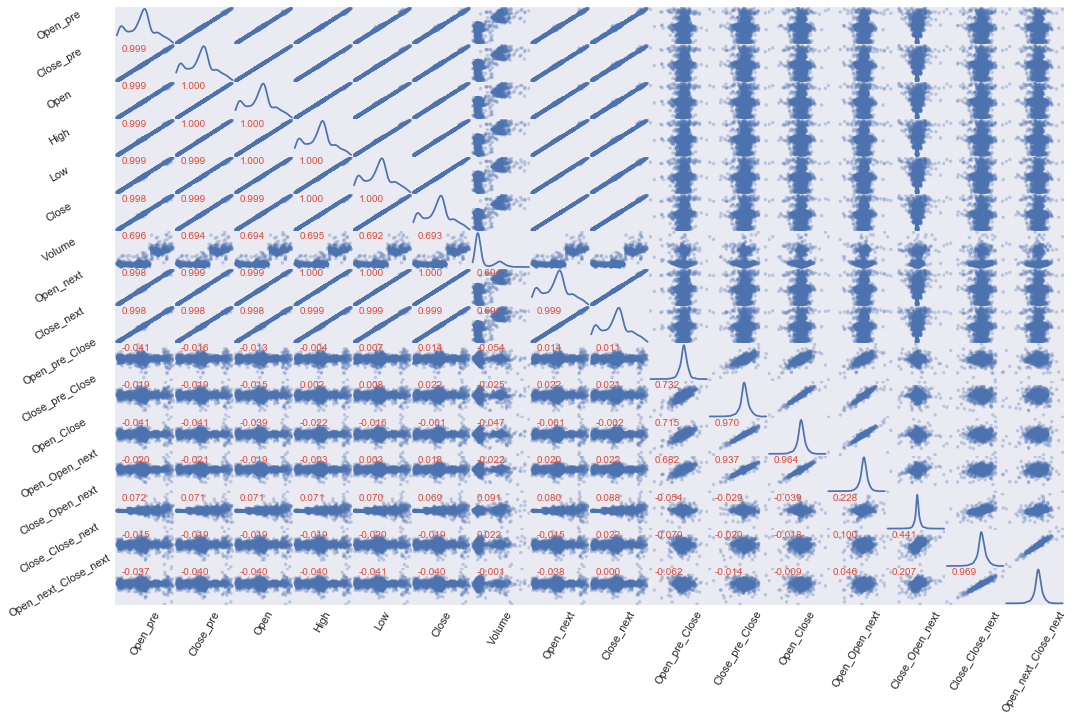

In [12]:
# print 'Produce a scatter matrix for each pair of features in the data'
data_corr = d  [[c for c in d.columns if c.find('up') < 0]]
mtrx_corr = data_corr.corr().as_matrix()
axs       = pd.plotting.scatter_matrix(data_corr, alpha = 0.3, figsize = (Page_size, Page_size*2/3), diagonal = 'kde')
for          i, j in  zip (*np.tril_indices_from(axs, k = 0)):
    ax = axs[i, j]
    if       i!=j:
        ax.annotate('%.3f' %mtrx_corr[i, j], ( 0.1, 0.8), xycoords = 'axes fraction', color = R)
    ax.get_yaxis().set_label_coords          (-0.9, 0.4)
    ax.xaxis.label.set_rotation(60)
    ax.yaxis.label.set_rotation(30)
    ax.set_xticks(())
    ax.set_yticks(())

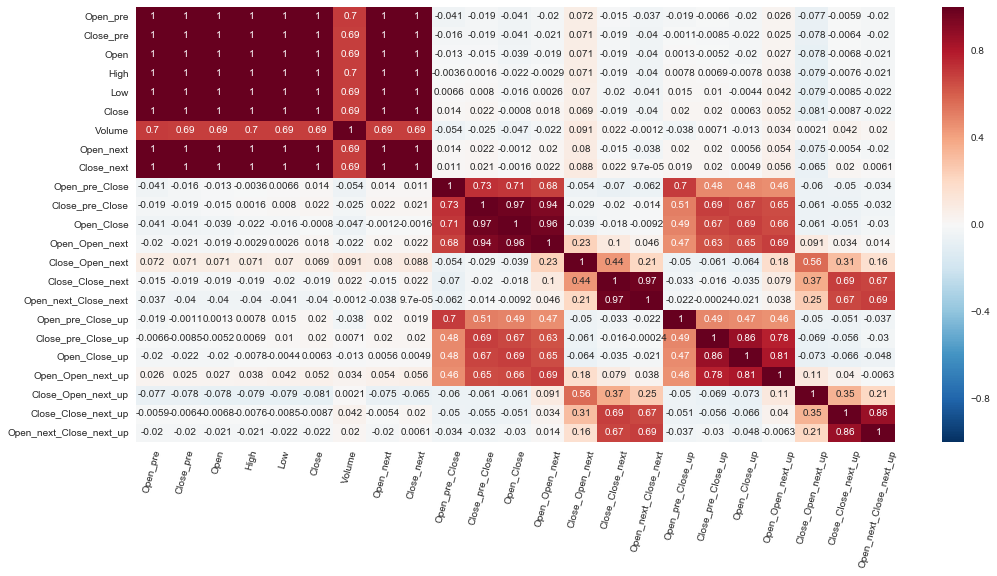

In [13]:
def corr_heatmap (data) :
    corr =        data  .corr()
    _, _ = plt.subplots (figsize     = (Page_size, Page_size/ 2))
    heat = sns.heatmap  (corr, annot =  True)
    heat.set_xticklabels(heat.get_xticklabels()  , rotation = 75)
corr_heatmap     (d   )

In [14]:
from stockstats import StockDataFrame
# from copy       import deepcopy
# s_copy  =              deepcopy(d     )
# s       = StockDataFrame.retype(s_copy)          # The data => StockDataFrame
s       = StockDataFrame.retype(d.copy())          # The data => StockDataFrame
stats   = ['volume_delta', 'open_-2_r', 'cr', 'cr-ma1', 'cr-ma2', 'cr-ma3', 'volume_-3,2,-1_max', 'volume_-3~1_min',
           'kdjk', 'kdjd', 'kdjj', 'open_2_sma', 'macd', 'macds', 'macdh', 'boll', 'boll_ub', 'boll_lb', 'cr-ma2_xu_cr-ma1_20_c',
           'rsi_6', 'rsi_12', 'wr_10', 'wr_6', 'cci', 'cci_20', 'tr', 'atr', 'dma', 'pdi', 'mdi', 'dx', 'adx', 'adxr',
           'trix', 'trix_9_sma', 'vr', 'vr_6_sma'] # Examples from the Tutorial of the stockstats

In [15]:
# [ s[stat] for stat in  stats]                    # Generate relative statistics
for             stat in  stats:                    # Generate relative statistics
    s[stat]                                        # The SettingWithCopyWarning might in stockstats.StockDataFrame

C:\ProgramData\Anaconda2\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [16]:
def display_corr(        data, corr,     n   = 5):
    print '\nTop {} Positive/Negative Correlation with {} of Statistics'                                      .format(n, corr)
    corr   =    (        data. corr()[corr].sort_values(by = corr, ascending = False)*100).applymap('{:6.2f}%'.format)
    display     (  concat    ([corr.head(n   = n)      .reset_index().rename(columns = {'index': 'Features'}) ,
                               corr.tail(n   = n)[::-1].reset_index().rename(columns = {'index': 'Features'})],
                  ['Positive Correlation', 'Negitive Correlation'])  .rename(index   = lambda i: i + 1))
def display_n   (        data, corr = False, right = '',
                                         n   = 5):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display ((       data. loc[:, right:] if right else data).describe())
        if          corr:
            display_corr(data, corr ,    n   = n)

_max = lambda s: max([int(n) for n in s.split('_') if n.isdigit()] or [1])

print 'Some raw and side statistics examples of the stockstats might incomplete in the first few days:'
display_n  (  s, right = stats[0])                          # display only new features

print '\nThe statistics with the most day number of data:'
stats_days = pd.DataFrame([(c, _max(c)) for c in s.columns],                 columns = ['Statistics', 'Days']
                                                               ).sort_values(by      =                'Days', ascending = False
                                                               ).reset_index(drop    = 1
                                                               ).     rename(index   = lambda i: i + 1)
display                 (stats_days.head())
stats_day  =         max(stats_days.Days  )
s_cplt     = s     .iloc[stats_day:-  stats_day                      ]
s_cplt     = s_cplt. loc[         :, (s_cplt  != s_cplt.iloc[0]).any()]
print 'Dropped the first, last {} days and constant statistics are dropped to complete integrity'.format(stats_day)

Some raw and side statistics examples of the stockstats might incomplete in the first few days:


,volume_delta,open_-2_r,middle,cr,cr-ma1,cr-ma2,cr-ma3,volume_-3_s,volume_-1_s,volume_2_s,"volume_-3,2,-1_max",volume_-2_s,volume_0_s,volume_1_s,volume_-3~1_min,rsv_9,kdjk_9,kdjk,kdjd_9,kdjd,kdjj_9,kdjj,open_2_sma,close_26_ema,macd,macds,macdh,close_20_sma,close_20_mstd,boll,boll_ub,boll_lb,cr-ma1_20_c,close_-1_s,close_-1_d,rs_6,rsi_6,rs_12,rsi_12,wr_10,wr_6,middle_14_sma,cci,middle_20_sma,cci_20,tr,atr,close_10_sma,close_50_sma,dma,high_delta,um,low_delta,dm,pdm,pdm_14_ema,pdm_14,atr_14,pdi_14,pdi,mdm,mdm_14_ema,mdm_14,mdi_14,mdi,dx_14,dx,dx_6_ema,adx,adx_6_ema,adxr,trix,trix_9_sma,change,vr,vr_6_sma
count,1.564000e+03,1563.000000,1565.000000,1564.000000,1560.000000,1558.000000,1554.000000,1.562000e+03,1.564000e+03,1.563000e+03,1.565000e+03,1.563000e+03,1.565000e+03,1.564000e+03,1.565000e+03,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1564.000000,1565.000000,1564.000000,1564.000000,1541.0,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1565.000000,1565.000000,1565.000000,1564.000000,1565.000000,1564.000000,1564.000000,1564.000000,1565.000000,1565.000000,1565.000000,1564.000000,1564.000000,1564.000000,1564.00000,1565.000000,1565.000000,1565.000000,1564.000000,1564.000000,1564.000000,1565.000000,1565.000000,1565.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1561.000000
mean,9.314254e+05,0.095780,1964.609764,inf,124.090082,124.472076,124.942587,8.977678e+08,8.992478e+08,9.003306e+08,1.037705e+09,8.985928e+08,9.000359e+08,9.001792e+08,7.649984e+08,63.210272,63.194294,63.194294,63.193758,63.193758,63.195368,63.195368,1964.174537,1954.433298,6.053277,6.120364,-0.134175,1957.113245,23.076453,1957.113245,2003.681159,1911.375347,20.0,1964.696349,0.862423,inf,56.990172,inf,56.407996,36.408858,38.071457,1959.137674,27.222546,1956.557548,32.106180,18.594514,18.268180,1961.350843,1943.921727,17.429116,0.867864,4.658274,0.859840,4.71172,4.515783,4.492922,4.492922,18.268180,25.261940,25.261940,4.614019,4.556859,4.556859,23.165409,23.165409,31.660426,31.660426,31.756714,31.756714,31.853678,31.853678,0.046116,0.046733,0.048441,inf,125.018902
std,2.635331e+08,1.072645,377.510393,NaN,48.705507,46.346140,41.707064,6.674477e+08,6.683190e+08,6.692095e+08,7.494671e+08,6.680305e+08,6.688323e+08,6.690222e+08,5.734525e+08,30.678213,23.317318,23.317318,20.321481,20.321481,36.443947,36.443947,377.664477,374.855389,13.304092,12.098360,9.481143,376.222850,13.453989,376.222850,383.519437,370.256496,0.0,377.168133,15.674302,NaN,17.472841,NaN,12.128528,30.551910,31.096797,376.794321,105.862562,376.336621,108.458298,12.444437,7.046367,376.882406,372.697480,37.837635,11.893241,7.150970,15.072137,10.05729,7.187126,2.177328,2.177328,7.046367,9.469604,9.469604,10.077108,3.894410,3.894410,11.725240,11.725240,21.145176,21.145176,15.393561,15.393561,13.489602,13.489602,0.107647,0.103025,0.789745,NaN,52.069498
min,-1.854808e+09,-6.911553,1275.823333,35.036925,44.631415,52.251135,55.682846,1.839316e+08,1.839316e+08,1.839316e+08,3.782322e+08,1.839316e+08,1.839316e+08,1.839316e+08,1.839316e+08,0.000000,4.666604,4.666604,9.879499,9.879499,-22.128273,-22.128273,1278.055000,1308.040000,-47.639949,-40.305676,-61.144555,1308.040000,3.228371,1308.040000,1320.170742,1270.300916,20.0,1278.040000,-113.190000,0.067665,6.337629,0.174513,14.858333,0.000000,0.000000,1302.380000,-340.578134,1302.380000,-395.599439,3.700000,6.807037,1305.426000,1308.040000,-125.243000,-72.360000,0.000000,-121.800000,0.00000,0.000000,0.000000,0.000000,6.807037,4.532342,4.532342,0.000000,0.000000,0.000000,0.000000,0.000000,0.010822,0.010822,6.959956,6.959956,10.029961,10.029961,-0.368495,-0.346507,-4.097924,34.691762,46.627682
25%,-6.635508e+07,-0.418194,1677.276667,88.728540,91.015089,91.929787,94.670118,4.980727e+08,4.980904e+08,4.980816e+08,5.645439e+08,4.980816e+


The statistics with the most day number of data:


,Statistics,Days
1,close_50_sma,50
2,close_26_ema,26
3,close_20_sma,20
4,close_20_mstd,20
5,cr-ma1_20_c,20


Dropped the first, last 50 days and constant statistics are dropped to complete integrity


In [17]:
display_n(s_cplt, right = stats[0], corr = ['close_close_next_up', 'close_close_next'], n = 10)

,volume_delta,open_-2_r,middle,cr,cr-ma1,cr-ma2,cr-ma3,volume_-3_s,volume_-1_s,volume_2_s,"volume_-3,2,-1_max",volume_-2_s,volume_0_s,volume_1_s,volume_-3~1_min,rsv_9,kdjk_9,kdjk,kdjd_9,kdjd,kdjj_9,kdjj,open_2_sma,close_26_ema,macd,macds,macdh,close_20_sma,close_20_mstd,boll,boll_ub,boll_lb,close_-1_s,close_-1_d,rs_6,rsi_6,rs_12,rsi_12,wr_10,wr_6,middle_14_sma,cci,middle_20_sma,cci_20,tr,atr,close_10_sma,close_50_sma,dma,high_delta,um,low_delta,dm,pdm,pdm_14_ema,pdm_14,atr_14,pdi_14,pdi,mdm,mdm_14_ema,mdm_14,mdi_14,mdi,dx_14,dx,dx_6_ema,adx,adx_6_ema,adxr,trix,trix_9_sma,change,vr,vr_6_sma
count,1.465000e+03,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1.465000e+03,1.465000e+03,1.465000e+03,1.465000e+03,1.465000e+03,1.465000e+03,1.465000e+03,1.465000e+03,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000
mean,1.080672e+06,0.100897,1960.137138,123.029475,122.340920,121.841412,121.282687,8.534573e+08,8.559514e+08,8.592273e+08,9.896245e+08,8.547479e+08,8.570321e+08,8.580936e+08,7.262289e+08,63.224161,63.196464,63.196464,63.176122,63.176122,63.237146,63.237146,1959.579973,1948.960523,6.454444,6.374197,0.160496,1951.591761,22.237420,1951.591761,1996.066600,1907.116921,1959.716184,1.001590,1.839121,56.979329,1.475556,56.281963,36.404473,37.959482,1953.847173,27.074372,1951.021065,32.172193,17.762396,17.700332,1956.322885,1937.962071,18.360814,0.996055,4.540874,0.989065,4.346280,4.405147,4.375662,4.375662,17.700332,25.184983,25.184983,4.256792,4.270924,4.270924,22.978293,22.978293,31.285586,31.285586,31.183422,31.183422,31.105374,31.105374,0.046857,0.046652,0.051720,123.291725,123.235977
std,2.576208e+08,1.035364,347.678046,49.215256,45.199812,41.300314,35.358253,6.172302e+08,6.197137e+08,6.229345e+08,6.949987e+08,6.185848e+08,6.207038e+08,6.216282e+08,5.312246e+08,30.745374,23.362168,23.362168,20.362918,20.362918,36.457553,36.457553,347.354551,342.064452,13.015985,11.918962,8.768370,343.082336,11.581147,343.082336,344.959384,342.763747,347.299350,14.431256,1.521031,17.354664,0.761791,11.805285,30.638299,31.106629,344.278289,105.875766,343.043433,108.387033,10.369001,5.594996,345.287559,338.564131,37.138512,11.193429,6.899772,13.366631,8.573763,6.935667,2.010087,2.010087,5.594996,9.463946,9.463946,8.594551,3.088374,3.088374,11.151570,11.151570,20.840421,20.840421,14.832601,14.832601,12.518852,12.518852,0.107165,0.103086,0.762731,53.700885,51.278427
min,-1.854808e+09,-6.686069,1275.823333,35.036925,44.631415,52.251135,55.682846,1.839316e+08,1.839316e+08,1.839316e+08,3.782322e+08,1.839316e+08,1.839316e+08,1.839316e+08,1.839316e+08,0.000000,4.666604,4.666604,9.879499,9.879499,-22.128273,-22.128273,1278.055000,1324.033020,-47.639949,-40.305676,-47.470134,1310.821000,5.550314,1310.821000,1341.444192,1270.300916,1278.040000,-77.680000,0.067665,6.337629,0.174513,14.858333,0.000000,0.000000,1306.971190,-340.578134,1310.760500,-395.599439,3.700000,9.318114,1305.426000,1332.767800,-125.243000,-72.360000,0.000000,-103.880000,0.000000,0.000000,0.922930,0.922930,9.318114,4.532342,4.532342,0.000000,0.257627,0.257627,2.451626,2.451626,0.010822,0.010822,6.959956,6.959956,10.029961,10.029961,-0.368495,-0.346507,-3.941367,34.691762,46.627682
25%,-6.436928e+07,-0.400815,1691.196667,89.631784,91.262829,91.877101,94.265942,4.941952e+08,4.941952e+08,4.941952e+08,5.592929e+


Top 10 Positive/Negative Correlation with ['close_close_next_up', 'close_close_next'] of Statistics


Positive Correlation                                       \
                   Features close_close_next_up close_close_next   
1       close_close_next_up             100.00%           71.51%   
2   open_next_close_next_up              86.13%           69.68%   
3          close_close_next              71.51%          100.00%   
4      open_next_close_next              69.39%           97.78%   
5           close_open_next              36.77%           48.28%   
6        close_open_next_up              35.59%           40.60%   
7                    volume               5.53%            5.86%   
8                volume_0_s               5.53%            5.86%   
9                      wr_6               5.27%            6.33%   
10                    wr_10               5.25%            6.51%   

   Negitive Correlation                                       
               Features close_close_next_up close_close_next  
1         open_close_up              -7.84%           -4.79%  
2    close_pre_close_up              -6.64%           -3.75%  
3            open_close              -5.62%           -1.80%  
4                rsi_12              -5.51%           -6.35%  
5            close_-1_d              -5.51%           -1.96%  
6       close_pre_close              -5.51%           -1.96%  
7                 rsv_9              -5.36%           -6.28%  
8                 rsi_6              -5.35%           -6.22%  
9                  rs_6              -5.24%           -3.51%  
10               change              -5.03%           -1.64%

In [18]:
X_stat, days_max = [], 0
for    col          ,   stat     in [
     ('RSI12'       ,  'rsi_12'     ),          # 12 days Relative Strength Index (RSI)
     ('RSI6'        ,  'rsi_6'      ),          #  6 days Relative Strength Index (RSI)
     ('WR10'        ,  'wr_10'      ),          # 10 days Williams Overbought/Oversold Index
     ('WR6'         ,  'wr_6'       ),          #  6 days Williams Overbought/Oversold Index
     ('C2M'         ,  'close_2_sma'),          #  2 days simple moving average (rolling means) on close price
     ('MACD'        ,  'macd'       ),          # Moving Average Convergence Divergence (MACD)
     ('Boll_u'      ,  'boll_ub'    ),          # Bollinger Upper Bands
     ('Boll'        ,  'boll'       ),          # Bollinger       Bands
     ('Boll_l'      ,  'boll_lb'    ),          # Bollinger Lower Bands
                                    ]:
    d[ col      ]   = s[stat        ]
    X_stat.append      ( col)
    days_cur     = _max(stat)
    if  days_max <  days_cur:
        days_max =  days_cur
        stat_max =      stat
        col_max  =       col
X_all   += X_stat
display(   d.loc[        :,       X_stat[0]:].head(n = days_max))
data_raw = d    [days_max:                  ]
display(   d.loc[        :,       X_stat[0]:].head(n = days_max))
print 'The first {} days w/o sufficient data for {}-day {} be dropped'.format(days_max - 1, days_max, stat_max)
display(   d.loc[        :,         col_max:].tail(n = days_max))

,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
2012-01-19,NaN,NaN,0.408879,0.408879,1308.040,0.000000,NaN,1308.040000,NaN
2012-01-20,100.000000,100.000000,4.040816,4.040816,1311.270,0.144936,1320.405820,1311.270000,1302.134180
2012-01-21,100.000000,100.000000,0.448980,0.448980,1314.940,0.211966,1320.655884,1312.640000,1304.624116
2012-01-24,100.000000,100.000000,20.070310,20.070310,1315.690,0.259643,1320.837028,1313.480000,1306.122972
2012-01-25,82.315081,78.282565,24.384787,24.384787,1315.325,0.226364,1320.170742,1313.714000,1307.257258
2012-01-26,93.277192,93.218876,6.003752,6.003752,1320.355,0.690002,1327.389215,1315.771667,1304.154118
2012-01-27,64.232195,60.067847,35.404896,54.870485,1322.245,0.629801,1326.945454,1316.151429,1305.357403
2012-01-28,58.740379,53.754183,40.348399,62.531923,1317.380,0.479432,1326.167874,1316.173750,1306.179626
2012-01-31,51.191713,44.817317,48.163842,62.037599,1314.670,0.203292,1325.405843,1315.822222,1306.238602
2012-02-01,49.926777,43.257655,49.576271,63.856883,1312.710,-0.026457,1324.770671,1315.481000,1306.191329


,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
2012-01-19,NaN,NaN,0.408879,0.408879,1308.040,0.000000,NaN,1308.040000,NaN
2012-01-20,100.000000,100.000000,4.040816,4.040816,1311.270,0.144936,1320.405820,1311.270000,1302.134180
2012-01-21,100.000000,100.000000,0.448980,0.448980,1314.940,0.211966,1320.655884,1312.640000,1304.624116
2012-01-24,100.000000,100.000000,20.070310,20.070310,1315.690,0.259643,1320.837028,1313.480000,1306.122972
2012-01-25,82.315081,78.282565,24.384787,24.384787,1315.325,0.226364,1320.170742,1313.714000,1307.257258
2012-01-26,93.277192,93.218876,6.003752,6.003752,1320.355,0.690002,1327.389215,1315.771667,1304.154118
2012-01-27,64.232195,60.067847,35.404896,54.870485,1322.245,0.629801,1326.945454,1316.151429,1305.357403
2012-01-28,58.740379,53.754183,40.348399,62.531923,1317.380,0.479432,1326.167874,1316.173750,1306.179626
2012-01-31,51.191713,44.817317,48.163842,62.037599,1314.670,0.203292,1325.405843,1315.822222,1306.238602
2012-02-01,49.926777,43.257655,49.576271,63.856883,1312.710,-0.026457,1324.770671,1315.481000,1306.191329


The first 11 days w/o sufficient data for 12-day rsi_12 be dropped


,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
2018-03-24,27.117775,12.184685,98.902829,98.653103,2615.975,-16.639318,2819.488351,2723.9460,2628.403649
2018-03-27,41.951022,41.107915,66.362668,53.270307,2623.405,-18.657749,2813.926644,2717.8935,2621.860356
2018-03-28,36.635903,32.670391,86.021337,82.557912,2635.585,-23.690448,2817.265582,2711.3105,2605.355418
2018-03-29,35.814648,31.387795,89.211923,87.530179,2608.810,-27.971332,2821.971635,2705.8690,2589.766365
2018-03-30,42.440658,43.841743,68.754262,49.922579,2622.935,-28.145115,2823.140737,2704.0290,2584.917263
2018-04-03,35.808719,32.279134,85.030387,76.789552,2611.375,-32.666283,2829.588913,2698.5605,2567.532087
2018-04-04,41.330727,42.352392,67.276357,49.867747,2598.165,-33.238067,2829.004256,2693.2360,2557.467744
2018-04-05,46.032940,50.547925,50.960397,24.871880,2629.570,-30.894956,2825.445263,2689.0645,2552.683737
2018-04-06,48.723799,55.141173,23.146321,7.811972,2653.765,-27.259243,2821.519188,2685.8665,2550.213812
2018-04-07,41.469541,40.591215,58.117044,57.160974,2633.655,-28.756400,2817.026839,2679.1415,2541.256161


In [19]:
display_corr(d, corr = ['Close_Close_next_up', 'Close_Close_next'], n = 10)


Top 10 Positive/Negative Correlation with ['Close_Close_next_up', 'Close_Close_next'] of Statistics


Positive Correlation                                       \
                   Features Close_Close_next_up Close_Close_next   
1       Close_Close_next_up             100.00%           69.04%   
2   Open_next_Close_next_up              86.11%           67.26%   
3          Close_Close_next              69.04%          100.00%   
4      Open_next_Close_next              66.72%           96.93%   
5        Close_Open_next_up              34.53%           37.33%   
6           Close_Open_next              31.22%           44.10%   
7                      WR10               5.47%            5.49%   
8                       WR6               5.03%            4.72%   
9                    Volume               4.21%            2.18%   
10        Open_Open_next_up               3.95%            7.88%   

   Negitive Correlation                                       
               Features Close_Close_next_up Close_Close_next  
1         Open_Close_up              -6.61%           -3.51%  
2                 RSI12              -5.80%           -6.34%  
3                  RSI6              -5.63%           -5.55%  
4    Close_pre_Close_up              -5.63%           -1.56%  
5       Close_pre_Close              -5.51%           -1.99%  
6                  MACD              -5.25%           -7.25%  
7            Open_Close              -5.07%           -1.83%  
8     Open_pre_Close_up              -5.06%           -3.26%  
9        Open_pre_Close              -5.00%           -7.05%  
10                Close              -0.87%           -1.94%

Test Data


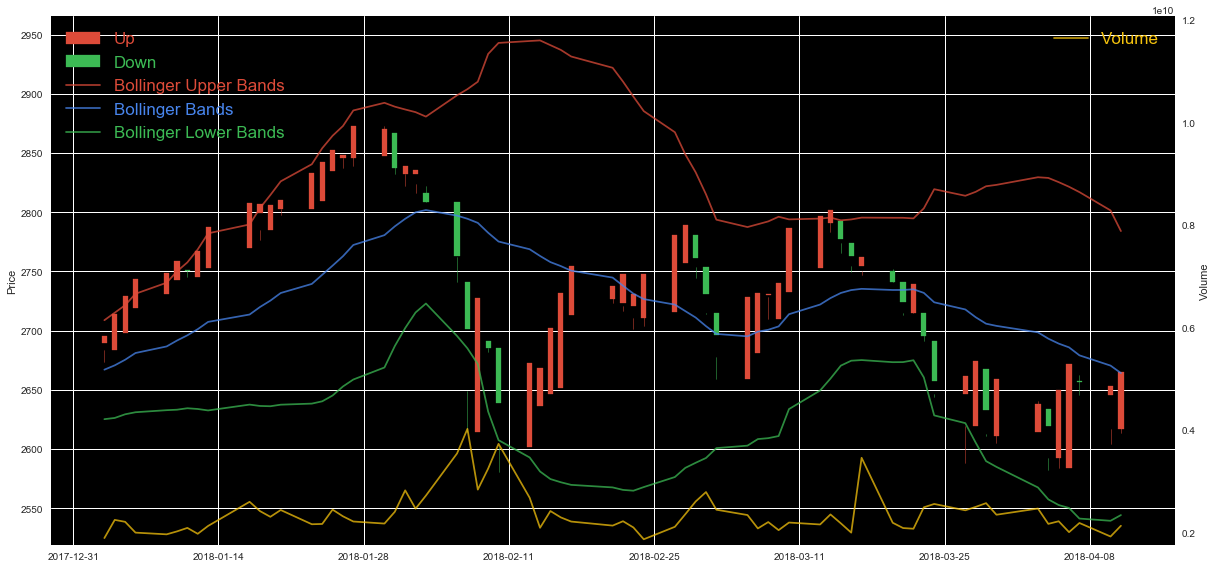

All Data


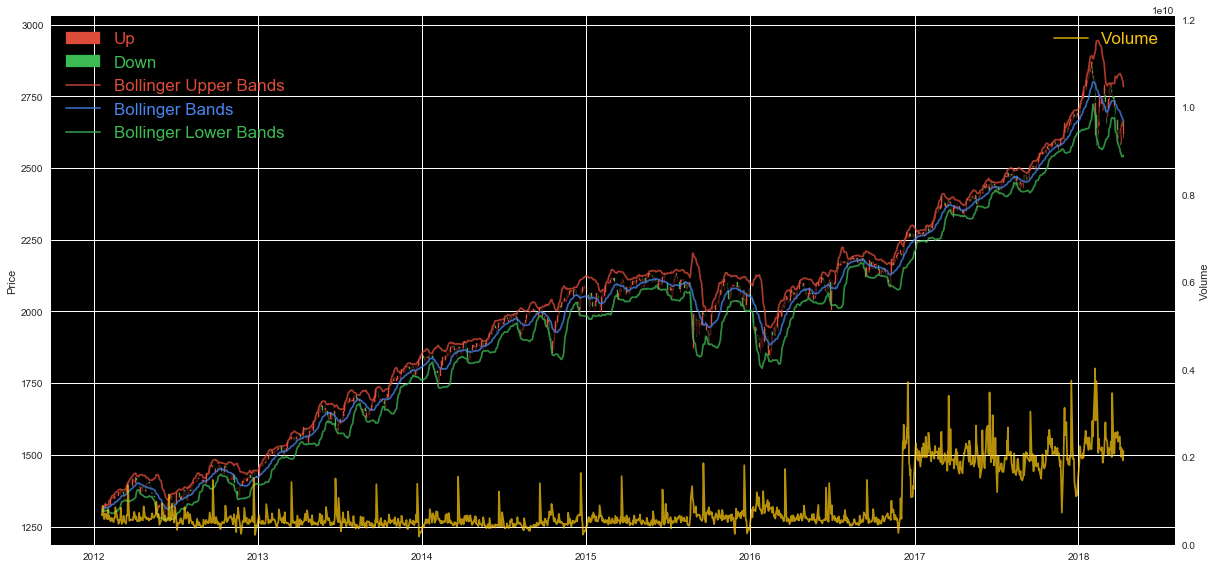

In [20]:
# Candle Stick Plot of open, high, low, close and Volume
from matplotlib.finance import candlestick_ohlc #, volume_overlay3
from matplotlib.patches import Patch

def FigStock(    x, size = 16, boll = False):
    x=           x. reset_index()
    x['index'] = x      ['index'].apply (dates.  date2num)
    fig, axP   = plt.subplots(figsize = (size , size/2  ))
    candlestick_ohlc(axP, x.values,    colorup = R ,   colordown = G, width = .5)
    axP. set_facecolor  ('#000000')
    axP.xaxis_date()
    axP. set_prop_cycle (  'color' ,      [      R ,  B    ,       G ])
    if  boll:
        boll = axP.plot (x['index'],    x[['Boll_u', 'Boll', 'Boll_l']].values, alpha = 0.75)
    axV      = axP.twinx()
    axV           .plot (x['index'],    x[ 'Volume'                   ].values, alpha = 0.75, label = 'Volume', color = Y)
    axV.grid      (False)
    axV.set_ylim  (None            ,  3*x[ 'Volume'].max())
    axV.set_ylabel(                        'Volume')
    axP.set_ylabel(                        'Price' )
    axV                   .legend( prop   = {'size': size}, loc = 'best'         ).get_texts()[0].set_color(Y)
    for text, c in zip(axP.legend([Patch(color = R), Patch(color = G)] +   boll,
                                  [            'Up',              'Down', 'Bollinger Upper Bands' ,
                                                                          'Bollinger Bands'       ,
                                                                          'Bollinger Lower Bands'],
                                   prop   = {'size': size}, loc = 'upper left'   ).get_texts()    ,
                                  [              R ,               G,      R, B, G]):
        text.set_color(c)
    plt.tight_layout()
    return axP, x

print 'Test Data'
FigStock(d[date_split:], Page_size, boll = True);
plt.show()
print  'All Data'
FigStock(d             , Page_size, boll = True);

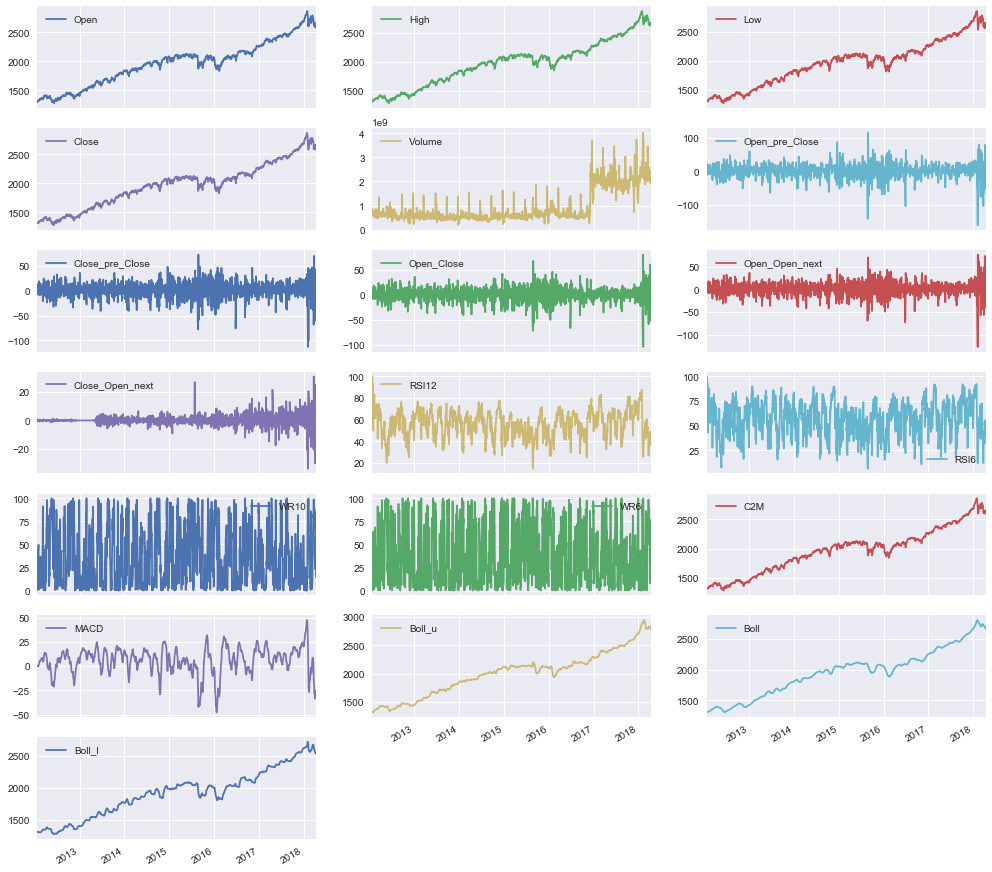

In [21]:
def subplot(data):
    data.plot(figsize = (Page_size, Page_size), subplots = True, layout = (len(data.columns)/3 + 1, 3));
subplot (d[X_base + X_vec + X_stat])

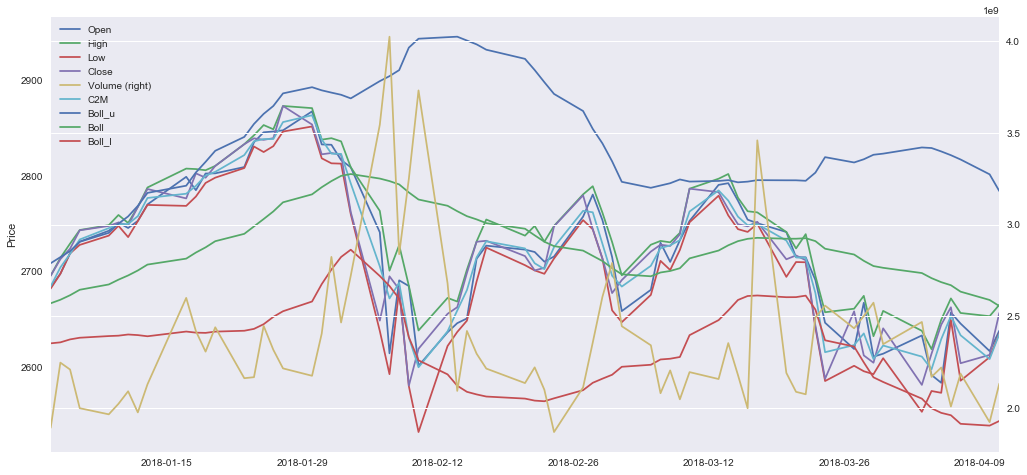

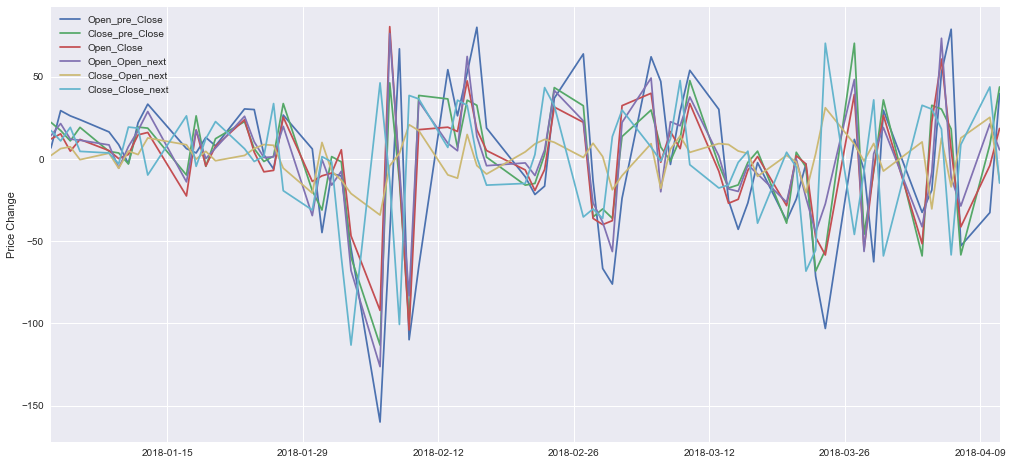

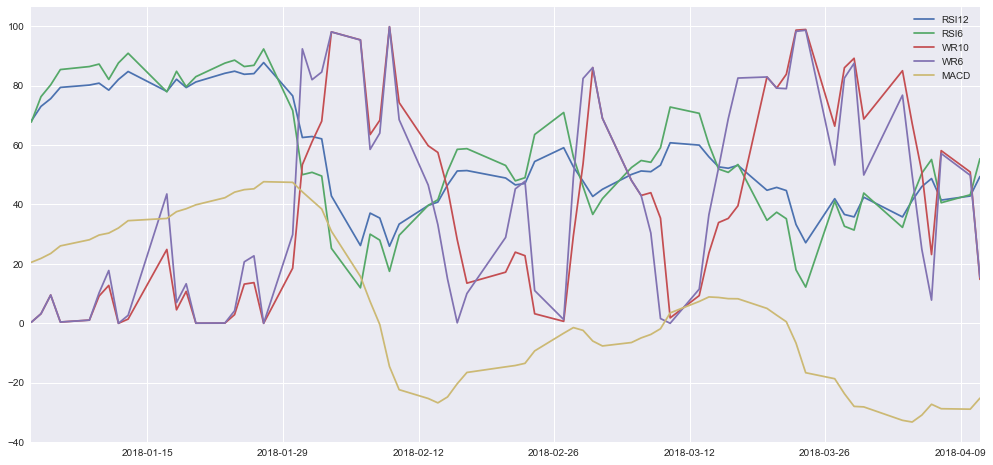

In [22]:
third_y =  ['C2M', 'Boll']
d_test  = d[date_split  :]
def plot( data,     ylabel = ''            , secondary_y = None       ):
    ax  = data.plot       (                  secondary_y = secondary_y, figsize = (Page_size, Page_size/2));
    ax        . set_ylabel(ylabel)

plot    ( d_test          [X_base + [x for x in X_stat if any([0 <= x.find(s) for s in third_y])]],
                          'Price'          ,              'Volume'                                )
plot    ( d_test          [X_vec  + ['Close_Close_next'                                         ]],
                          'Price Change'                                                          )
plot    ( d_test          [         [x for x in X_stat if all([0 >  x.find(s) for s in third_y])]])

----
## Preparing the Data
### Normalizing Numerical Features
We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) first and try others later.

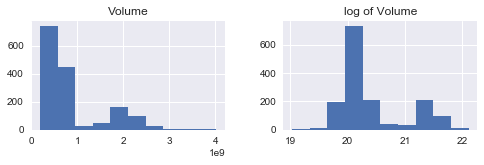

In [23]:
# Try Log-transform for the special feature
log           = ['Volume']
data_log      = data_raw     .copy  ()
data_log[log] = data_log[log].apply (          lambda x: np.log(x  + 1))
concat( [       data_raw[log],
                data_log[log].rename(columns = lambda c: 'log of ' + c)]).hist(figsize = (8, 2));

In [24]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
numerical = [c for c in data_raw.columns if c.find('up') < 0]
for data_scale, name in ((data_raw, 'data_raw'), (data_log, 'data_log'),):
    for scaler in (  RobustScaler(), StandardScaler(), MinMaxScaler(),):
        data_scaled                  =                           data_scale .copy()
        data_scaled[numerical]       =      scaler.fit_transform(data_scaled[numerical])
        print '\n[{} with {}]'.format(name, class_name(scaler))
#         display(data_scaled.head(n = 5)) # Show examples of records with scaling applied
        display(data_scaled.tail(n = 5))
        display(data_scaled.describe())


[data_raw with RobustScaler]


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next_up,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
2018-04-05,1.211638,1.267327,1.193483,1.305329,1.206067,1.328813,4.467391,1.347607,1.359873,2.453437,...,True,-0.670197,-0.302314,0.421393,-0.118047,1.295941,-2.519522,1.567597,1.432423,1.208962
2018-04-06,1.194814,1.330267,1.345174,1.351388,1.364341,1.366676,3.889366,1.323619,1.238213,3.734764,...,False,-0.513224,-0.122462,-0.121390,-0.434873,1.346380,-2.282633,1.559365,1.425795,1.204015
2018-04-07,1.346543,1.368043,1.321299,1.319881,1.232442,1.244910,4.376026,1.264083,1.256326,-2.686007,...,False,-0.936407,-0.692174,0.561053,0.481604,1.304457,-2.380182,1.549946,1.411857,1.186070
2018-04-10,1.322662,1.246555,1.262046,1.312978,1.283527,1.263038,3.658406,1.308215,1.347430,-1.699659,...,True,-0.855793,-0.587453,0.420879,0.345161,1.252674,-2.390089,1.517504,1.393886,1.182328
2018-04-11,1.263394,1.264642,1.305969,1.337645,1.335590,1.354222,4.227882,1.319607,1.316833,1.827889,...,False,-0.473428,-0.112797,-0.284186,-0.293092,1.307292,-2.149198,1.480932,1.380813,1.192000


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
count,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,...,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000
mean,-0.078406,-0.075471,-0.077670,-0.086964,-0.071162,-0.078362,0.882991,-0.080246,-0.082159,-0.040741,...,-0.036081,-0.073036,-0.054750,0.139379,0.128350,-0.079639,-0.109243,-0.145276,-0.074350,-0.067121
std,0.775613,0.779496,0.775477,0.778329,0.779020,0.781387,1.823721,0.779239,0.780810,1.030996,...,1.072808,0.697314,0.680786,0.597377,0.578212,0.780626,0.869566,0.797931,0.773897,0.737231
min,-1.508288,-1.514195,-1.508948,-1.528885,-1.516636,-1.522175,-1.067869,-1.520101,-1.526450,-7.907362,...,-7.812500,-2.488792,-2.033393,-0.573084,-0.579951,-1.521420,-3.610560,-1.551176,-1.424173,-1.359930
25%,-0.671026,-0.669275,-0.671294,-0.684369,-0.660055,-0.672522,-0.214669,-0.673596,-0.677415,-0.508045,...,-0.493304,-0.561045,-0.522952,-0.404191,-0.400846,-0.671840,-0.555441,-0.756681,-0.675961,-0.659218
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.328974,0.330725,0.328706,0.315631,0.339945,0.327478,0.785331,0.326404,0.322585,0.491955,...,0.506696,0.438955,0.477048,0.595809,0.599154,0.328160,0.444559,0.243319,0.324039,0.340782
max,1.780850,1.805187,1.779373,1.767593,1.784975,1.804823,9.368392,1.783873,1.797636,5.495368,...,5.905506,1.764793,1.334362,1.378386,1.277182,1.782985,2.598989,1.818595,1.666200,1.549988



[data_raw with StandardScaler]


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next_up,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
2018-04-05,1.663793,1.723204,1.639716,1.789400,1.640061,1.801448,1.966065,1.832959,1.847436,2.419971,...,True,-0.856650,-0.363761,0.472240,-0.426275,1.762717,-2.772712,2.147333,1.947622,1.731472
2018-04-06,1.642094,1.803974,1.835389,1.848595,1.843297,1.849920,1.649015,1.802164,1.691573,3.663176,...,False,-0.631466,-0.099494,-0.436665,-0.974391,1.827351,-2.500202,2.137014,1.939054,1.724759
2018-04-07,1.837782,1.852452,1.804592,1.808101,1.673929,1.694036,1.915951,1.725738,1.714778,-2.566565,...,False,-1.238537,-0.936607,0.706103,0.611138,1.773630,-2.612419,2.125206,1.921038,1.700411
2018-04-10,1.806982,1.696548,1.728158,1.799230,1.739525,1.717243,1.522332,1.782390,1.831494,-1.609562,...,True,-1.122894,-0.782733,0.471378,0.375088,1.707272,-2.623817,2.084535,1.897809,1.695334
2018-04-11,1.730543,1.719759,1.784816,1.830932,1.806379,1.833976,1.834693,1.797014,1.792295,1.813034,...,False,-0.574378,-0.085291,-0.709271,-0.729108,1.777263,-2.346702,2.038687,1.880911,1.708457


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
count,1.553000e+03,1.553000e+03,1.553000e+03,1.553000e+03,1.553000e+03,1.553000e+03,1.553000e+03,1.553000e+03,1.553000e+03,1.553000e+03,...,1.553000e+03,1.553000e+03,1.553000e+03,1.553000e+03,1.553000e+03,1.553000e+03,1.553000e+03,1.553000e+03,1.553000e+03,1.553000e+03
mean,7.360500e-16,3.342822e-16,-6.036525e-16,6.373953e-16,1.930201e-17,-7.124586e-16,1.544161e-16,7.396244e-16,6.780010e-16,-2.430623e-17,...,8.721649e-18,-6.600573e-16,1.259546e-16,-6.005070e-17,-1.508416e-17,2.053162e-16,-9.379347e-17,-2.201859e-17,-1.300241e-15,-2.021707e-16
std,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,...,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00
min,-1.844145e+00,-1.846305e+00,-1.846269e+00,-1.853183e+00,-1.856100e+00,-1.848352e+00,-1.070058e+00,-1.848365e+00,-1.850330e+00,-7.632575e+00,...,-7.250996e+00,-3.465491e+00,-2.907344e+00,-1.193037e+00,-1.225381e+00,-1.847549e+00,-4.027810e+00,-1.762499e+00,-1.744750e+00,-1.754166e+00
25%,-7.643135e-01,-7.620253e-01,-7.657420e-01,-7.677954e-01,-7.561849e-01,-7.606360e-01,-6.020727e-01,-7.616925e-01,-7.626023e-01,-4.534011e-01,...,-4.263295e-01,-7.000674e-01,-6.879586e-01,-9.102212e-01,-9.155238e-01,-7.588671e-01,-5.132930e-01,-7.664844e-01,-7.776283e-01,-8.033953e-01
50%,1.011210e-01,9.685136e-02,1.001897e-01,1.117674e-01,9.137747e-02,1.003177e-01,-4.843257e-01,1.030133e-01,1.052564e-01,3.952847e-02,...,3.364341e-02,1.047722e-01,8.044781e-02,-2.333935e-01,-2.220498e-01,1.020525e-01,1.256700e-01,1.821244e-01,9.610368e-02,9.107400e-02
75%,5.254044e-01,5.212683e-01,5.242019e-01,5.174223e-01,5.278927e-01,5.195513e-01,-5.356662e-02,5.220236e-01,5.185313e-01,5.168470e-01,...,5.061043e-01,7.344692e-01,7.814039e-01,7.643039e-01,8.145030e-01,5.225680e-01,6.370770e-01,4.871601e-01,5.149491e-01,5.534692e-01
max,2.397915e+00,2.413436e+00,2.395481e+00,2.383510e+00,2.383423e+00,2.410829e+00,4.654294e+00,2.393000e+00,2.408269e+00,5.371399e+00,...,5.540137e+00,2.636432e+00,2.041109e+00,2.074749e+00,1.987509e+00,2.386832e+00,3.115469e+00,2.461996e+00,2.249796e+00,2.194198e+00



[data_raw with MinMaxScaler]


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next_up,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
2018-04-05,0.826942,0.837964,0.821827,0.859770,0.824659,0.856925,0.530387,0.867957,0.868306,0.773036,...,True,0.427544,0.514016,0.509604,0.248719,0.852608,0.175703,0.925515,0.924353,0.882806
2018-04-06,0.821827,0.856925,0.867957,0.873742,0.872597,0.868306,0.475001,0.860697,0.831706,0.868638,...,False,0.464448,0.567420,0.231463,0.078120,0.867872,0.213852,0.923072,0.922208,0.881105
2018-04-07,0.867957,0.868306,0.860697,0.864185,0.832648,0.831706,0.521633,0.842677,0.837155,0.389574,...,False,0.364959,0.398253,0.581170,0.571610,0.855185,0.198143,0.920277,0.917698,0.874939
2018-04-10,0.860697,0.831706,0.842677,0.862091,0.848120,0.837155,0.452871,0.856035,0.864562,0.463167,...,True,0.383911,0.429348,0.509340,0.498140,0.839514,0.196547,0.910650,0.911883,0.873653
2018-04-11,0.842677,0.837155,0.856035,0.869573,0.863889,0.864562,0.507438,0.859482,0.855358,0.726363,...,False,0.473804,0.570290,0.148041,0.154463,0.856043,0.235341,0.899796,0.907653,0.876977


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
count,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,...,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000
mean,0.434729,0.433431,0.435261,0.437413,0.437809,0.433969,0.186931,0.435795,0.434493,0.586942,...,0.566877,0.567934,0.587526,0.365090,0.381395,0.436321,0.563860,0.417209,0.436783,0.444277
std,0.235810,0.234832,0.235828,0.236109,0.235952,0.234863,0.174749,0.235849,0.234895,0.076924,...,0.078204,0.163936,0.202148,0.306116,0.311346,0.236238,0.140037,0.236791,0.250422,0.253351
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.254554,0.254541,0.254736,0.256187,0.259443,0.255381,0.081753,0.256208,0.255419,0.552075,...,0.533547,0.453205,0.448501,0.086547,0.096442,0.257105,0.492003,0.235771,0.242111,0.240801
50%,0.458566,0.456168,0.458881,0.463793,0.459362,0.457522,0.102323,0.460083,0.459209,0.589981,...,0.569507,0.585105,0.603783,0.293668,0.312283,0.460422,0.581453,0.460321,0.460842,0.467343
75%,0.558585,0.555802,0.558843,0.559541,0.562326,0.555953,0.177573,0.558874,0.556254,0.626687,...,0.606444,0.688301,0.745435,0.598981,0.634906,0.559732,0.653046,0.532527,0.565696,0.584454
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



[data_log with RobustScaler]


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next_up,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
2018-04-05,1.211638,1.267327,1.193483,1.305329,1.206067,1.328813,2.436021,1.347607,1.359873,2.453437,...,True,-0.670197,-0.302314,0.421393,-0.118047,1.295941,-2.519522,1.567597,1.432423,1.208962
2018-04-06,1.194814,1.330267,1.345174,1.351388,1.364341,1.366676,2.254076,1.323619,1.238213,3.734764,...,False,-0.513224,-0.122462,-0.121390,-0.434873,1.346380,-2.282633,1.559365,1.425795,1.204015
2018-04-07,1.346543,1.368043,1.321299,1.319881,1.232442,1.244910,2.408453,1.264083,1.256326,-2.686007,...,False,-0.936407,-0.692174,0.561053,0.481604,1.304457,-2.380182,1.549946,1.411857,1.186070
2018-04-10,1.322662,1.246555,1.262046,1.312978,1.283527,1.263038,2.175925,1.308215,1.347430,-1.699659,...,True,-0.855793,-0.587453,0.420879,0.345161,1.252674,-2.390089,1.517504,1.393886,1.182328
2018-04-11,1.263394,1.264642,1.305969,1.337645,1.335590,1.354222,2.362840,1.319607,1.316833,1.827889,...,False,-0.473428,-0.112797,-0.284186,-0.293092,1.307292,-2.149198,1.480932,1.380813,1.192000


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
count,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,...,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000
mean,-0.078406,-0.075471,-0.077670,-0.086964,-0.071162,-0.078362,0.439633,-0.080246,-0.082159,-0.040741,...,-0.036081,-0.073036,-0.054750,0.139379,0.128350,-0.079639,-0.109243,-0.145276,-0.074350,-0.067121
std,0.775613,0.779496,0.775477,0.778329,0.779020,0.781387,1.065605,0.779239,0.780810,1.030996,...,1.072808,0.697314,0.680786,0.597377,0.578212,0.780626,0.869566,0.797931,0.773897,0.737231
min,-1.508288,-1.514195,-1.508948,-1.528885,-1.516636,-1.522175,-2.065713,-1.520101,-1.526450,-7.907362,...,-7.812500,-2.488792,-2.033393,-0.573084,-0.579951,-1.521420,-3.610560,-1.551176,-1.424173,-1.359930
25%,-0.671026,-0.669275,-0.671294,-0.684369,-0.660055,-0.672522,-0.266124,-0.673596,-0.677415,-0.508045,...,-0.493304,-0.561045,-0.522952,-0.404191,-0.400846,-0.671840,-0.555441,-0.756681,-0.675961,-0.659218
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.328974,0.330725,0.328706,0.315631,0.339945,0.327478,0.733876,0.326404,0.322585,0.491955,...,0.506696,0.438955,0.477048,0.595809,0.599154,0.328160,0.444559,0.243319,0.324039,0.340782
max,1.780850,1.805187,1.779373,1.767593,1.784975,1.804823,3.510345,1.783873,1.797636,5.495368,...,5.905506,1.764793,1.334362,1.378386,1.277182,1.782985,2.598989,1.818595,1.666200,1.549988



[data_log with StandardScaler]


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next_up,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
2018-04-05,1.663793,1.723204,1.639716,1.789400,1.640061,1.801448,1.874083,1.832959,1.847436,2.419971,...,True,-0.856650,-0.363761,0.472240,-0.426275,1.762717,-2.772712,2.147333,1.947622,1.731472
2018-04-06,1.642094,1.803974,1.835389,1.848595,1.843297,1.849920,1.703284,1.802164,1.691573,3.663176,...,False,-0.631466,-0.099494,-0.436665,-0.974391,1.827351,-2.500202,2.137014,1.939054,1.724759
2018-04-07,1.837782,1.852452,1.804592,1.808101,1.673929,1.694036,1.848204,1.725738,1.714778,-2.566565,...,False,-1.238537,-0.936607,0.706103,0.611138,1.773630,-2.612419,2.125206,1.921038,1.700411
2018-04-10,1.806982,1.696548,1.728158,1.799230,1.739525,1.717243,1.629921,1.782390,1.831494,-1.609562,...,True,-1.122894,-0.782733,0.471378,0.375088,1.707272,-2.623817,2.084535,1.897809,1.695334
2018-04-11,1.730543,1.719759,1.784816,1.830932,1.806379,1.833976,1.805385,1.797014,1.792295,1.813034,...,False,-0.574378,-0.085291,-0.709271,-0.729108,1.777263,-2.346702,2.038687,1.880911,1.708457


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
count,1.553000e+03,1.553000e+03,1.553000e+03,1.553000e+03,1.553000e+03,1.553000e+03,1.553000e+03,1.553000e+03,1.553000e+03,1.553000e+03,...,1.553000e+03,1.553000e+03,1.553000e+03,1.553000e+03,1.553000e+03,1.553000e+03,1.553000e+03,1.553000e+03,1.553000e+03,1.553000e+03
mean,7.360500e-16,3.342822e-16,-6.036525e-16,6.373953e-16,1.930201e-17,-7.124586e-16,-9.945539e-16,7.396244e-16,6.780010e-16,-2.430623e-17,...,8.721649e-18,-6.600573e-16,1.259546e-16,-6.005070e-17,-1.508416e-17,2.053162e-16,-9.379347e-17,-2.201859e-17,-1.300241e-15,-2.021707e-16
std,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,...,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00
min,-1.844145e+00,-1.846305e+00,-1.846269e+00,-1.853183e+00,-1.856100e+00,-1.848352e+00,-2.351859e+00,-1.848365e+00,-1.850330e+00,-7.632575e+00,...,-7.250996e+00,-3.465491e+00,-2.907344e+00,-1.193037e+00,-1.225381e+00,-1.847549e+00,-4.027810e+00,-1.762499e+00,-1.744750e+00,-1.754166e+00
25%,-7.643135e-01,-7.620253e-01,-7.657420e-01,-7.677954e-01,-7.561849e-01,-7.606360e-01,-6.625195e-01,-7.616925e-01,-7.626023e-01,-4.534011e-01,...,-4.263295e-01,-7.000674e-01,-6.879586e-01,-9.102212e-01,-9.155238e-01,-7.588671e-01,-5.132930e-01,-7.664844e-01,-7.776283e-01,-8.033953e-01
50%,1.011210e-01,9.685136e-02,1.001897e-01,1.117674e-01,9.137747e-02,1.003177e-01,-4.126992e-01,1.030133e-01,1.052564e-01,3.952847e-02,...,3.364341e-02,1.047722e-01,8.044781e-02,-2.333935e-01,-2.220498e-01,1.020525e-01,1.256700e-01,1.821244e-01,9.610368e-02,9.107400e-02
75%,5.254044e-01,5.212683e-01,5.242019e-01,5.174223e-01,5.278927e-01,5.195513e-01,2.762170e-01,5.220236e-01,5.185313e-01,5.168470e-01,...,5.061043e-01,7.344692e-01,7.814039e-01,7.643039e-01,8.145030e-01,5.225680e-01,6.370770e-01,4.871601e-01,5.149491e-01,5.534692e-01
max,2.397915e+00,2.413436e+00,2.395481e+00,2.383510e+00,2.383423e+00,2.410829e+00,2.882590e+00,2.393000e+00,2.408269e+00,5.371399e+00,...,5.540137e+00,2.636432e+00,2.041109e+00,2.074749e+00,1.987509e+00,2.386832e+00,3.115469e+00,2.461996e+00,2.249796e+00,2.194198e+00



[data_log with MinMaxScaler]


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next_up,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
2018-04-05,0.826942,0.837964,0.821827,0.859770,0.824659,0.856925,0.807333,0.867957,0.868306,0.773036,...,True,0.427544,0.514016,0.509604,0.248719,0.852608,0.175703,0.925515,0.924353,0.882806
2018-04-06,0.821827,0.856925,0.867957,0.873742,0.872597,0.868306,0.774703,0.860697,0.831706,0.868638,...,False,0.464448,0.567420,0.231463,0.078120,0.867872,0.213852,0.923072,0.922208,0.881105
2018-04-07,0.867957,0.868306,0.860697,0.864185,0.832648,0.831706,0.802389,0.842677,0.837155,0.389574,...,False,0.364959,0.398253,0.581170,0.571610,0.855185,0.198143,0.920277,0.917698,0.874939
2018-04-10,0.860697,0.831706,0.842677,0.862091,0.848120,0.837155,0.760688,0.856035,0.864562,0.463167,...,True,0.383911,0.429348,0.509340,0.498140,0.839514,0.196547,0.910650,0.911883,0.873653
2018-04-11,0.842677,0.837155,0.856035,0.869573,0.863889,0.864562,0.794208,0.859482,0.855358,0.726363,...,False,0.473804,0.570290,0.148041,0.154463,0.856043,0.235341,0.899796,0.907653,0.876977


,Open_pre,Close_pre,Open,High,Low,Close,Volume,Open_next,Close_next,Open_pre_Close,...,Open_next_Close_next,RSI12,RSI6,WR10,WR6,C2M,MACD,Boll_u,Boll,Boll_l
count,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,...,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000
mean,0.434729,0.433431,0.435261,0.437413,0.437809,0.433969,0.449304,0.435795,0.434493,0.586942,...,0.566877,0.567934,0.587526,0.365090,0.381395,0.436321,0.563860,0.417209,0.436783,0.444277
std,0.235810,0.234832,0.235828,0.236109,0.235952,0.234863,0.191104,0.235849,0.234895,0.076924,...,0.078204,0.163936,0.202148,0.306116,0.311346,0.236238,0.140037,0.236791,0.250422,0.253351
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.254554,0.254541,0.254736,0.256187,0.259443,0.255381,0.322735,0.256208,0.255419,0.552075,...,0.533547,0.453205,0.448501,0.086547,0.096442,0.257105,0.492003,0.235771,0.242111,0.240801
50%,0.458566,0.456168,0.458881,0.463793,0.459362,0.457522,0.370461,0.460083,0.459209,0.589981,...,0.569507,0.585105,0.603783,0.293668,0.312283,0.460422,0.581453,0.460321,0.460842,0.467343
75%,0.558585,0.555802,0.558843,0.559541,0.562326,0.555953,0.502073,0.558874,0.556254,0.626687,...,0.606444,0.688301,0.745435,0.598981,0.634906,0.559732,0.653046,0.532527,0.565696,0.584454
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Try log transformed X with MinMaxScaler first because it seems the most normal and cleanest.

### Implementation: Data Preprocessing


In [25]:
day_range_Max =  30

pre           =  '{}_pre{}'
def pre_data  (                         X0,             day_range_Max = 2):  # Combine previous daily data
    X         =                         X0.copy()
    for shf in range       ( 1,                         day_range_Max    ):
        X     =  concat    ([X,         X0.shift(shf).rename(columns = lambda c: pre.format(c, shf))])
    return                   X                        [ day_range_Max - 1 :] # Dropout days which lack previous daily data

pre_feature   = lambda feature, shf: list(feature) + [pre.format(f, s) for s in range(1, shf) for f in feature]

print      'Scaled/Normalized Features:'
X_display                  (data_scaled)

X             = pre_data   (data_scaled[X_all        ], day_range_Max      )
y             =             data_scaled[y_clf + y_rgr][ day_range_Max - 1 :]
X_pre         =[pre_feature( f,                         day_range_Max      ) for f in [X_base, X_vec, X_up, X_stat]]

concat_display             ( X,        [X.columns    ], ['{}-day previous data concated Features:'.format(day_range_Max - 1)])
y_display                  ( y                       );

Scaled/Normalized Features:


Base Features ~  X_base                                          \
                              Open      High       Low     Close    Volume   
2018-04-05                0.821827  0.859770  0.824659  0.856925  0.807333   
2018-04-06                0.867957  0.873742  0.872597  0.868306  0.774703   
2018-04-07                0.860697  0.864185  0.832648  0.831706  0.802389   
2018-04-10                0.842677  0.862091  0.848120  0.837155  0.760688   
2018-04-11                0.856035  0.869573  0.863889  0.864562  0.794208   

           Vector Features ~  X_vec                                            \
                     Open_pre_Close Close_pre_Close Open_Close Open_Open_next   
2018-04-05                 0.773036        0.770798   0.893095       0.985922   
2018-04-06                 0.868638        0.705825   0.593860       0.566757   
2018-04-07                 0.389574        0.294604   0.339860       0.482292   
2018-04-10                 0.463167        0.654987   0.542333       0.728624   
2018-04-11                 0.726363        0.843186   0.664262       0.650827   

                           Up Features ~  X_up                     \
           Close_Open_next   Open_pre_Close_up Close_pre_Close_up   
2018-04-05        0.717701                True               True   
2018-04-06        0.262682                True               True   
2018-04-07        0.718314               False              False   
2018-04-10        0.910498               False               True   
2018-04-11        0.324598                True               True   

                                                               
           Open_Close_up Open_Open_next_up Close_Open_next_up  
2018-04-05          True              True               True  
2018-04-06          True             False              False  
2018-04-07         False             False               True  
2018-04-10         False              True               True  
2018-04-11          True              True              False

29-day previous data concated Features:                      \
                                              Open      High       Low   
2018-04-05                                0.821827  0.859770  0.824659   
2018-04-06                                0.867957  0.873742  0.872597   
2018-04-07                                0.860697  0.864185  0.832648   
2018-04-10                                0.842677  0.862091  0.848120   
2018-04-11                                0.856035  0.869573  0.863889   

                                                                          \
               Close    Volume Open_pre_Close Close_pre_Close Open_Close   
2018-04-05  0.856925  0.807333       0.773036        0.770798   0.893095   
2018-04-06  0.868306  0.774703       0.868638        0.705825   0.593860   
2018-04-07  0.831706  0.802389       0.389574        0.294604   0.339860   
2018-04-10  0.837155  0.760688       0.463167        0.654987   0.542333   
2018-04-11  0.864562  0.794208       0.726363        0.843186   0.664262   

                                              ...       \
           Open_Open_next Close_Open_next     ...        
2018-04-05       0.985922        0.717701     ...        
2018-04-06       0.566757        0.262682     ...        
2018-04-07       0.482292        0.718314     ...        
2018-04-10       0.728624        0.910498     ...        
2018-04-11       0.650827        0.324598     ...        

                                                                       \
           Close_Open_next_up_pre29 RSI12_pre29 RSI6_pre29 WR10_pre29   
2018-04-05                     True    0.435201   0.483827   0.239435   
2018-04-06                     True    0.441811   0.496046   0.227574   
2018-04-07                     True    0.543129   0.665236   0.032111   
2018-04-10                     True    0.606781   0.751386   0.006574   
2018-04-11                     True    0.518918   0.577628   0.295061   

                                                                                
           WR6_pre29 C2M_pre29 MACD_pre29 Boll_u_pre29 Boll_pre29 Boll_l_pre29  
2018-04-05  0.452446  0.902589   0.350815     0.978351   0.957120     0.891612  
2018-04-06  0.478067  0.898709   0.358464     0.970461   0.952640     0.891147  
2018-04-07  0.110217  0.913210   0.402346     0.962835   0.949557     0.893254  
2018-04-10  0.012550  0.937070   0.464874     0.951752   0.946429     0.899095  
2018-04-11  0.491026  0.936117   0.484698     0.940156   0.942766     0.904405  

[5 rows x 720 columns]

y (Classification)                         y (Regressions)  \
           Close_Close_next_up Open_next_Close_next_up       Open_next   
2018-04-05                True                    True        0.867957   
2018-04-06               False                   False        0.860697   
2018-04-07                True                   False        0.842677   
2018-04-10                True                    True        0.856035   
2018-04-11               False                   False        0.859482   

                       
           Close_next  
2018-04-05   0.868306  
2018-04-06   0.831706  
2018-04-07   0.837155  
2018-04-10   0.864562  
2018-04-11   0.855358

### Split Data
All the features are numerical and normalized.
Split the data (both features and their labels) into training and test sets.
Data before 2018 will be used for training and the other for testing.

In [26]:
def Split1(        y, date):
    return         y[:date],        y[ date:]
def Split (        X,               y, date):
    return Split1( X, date), Split1(y, date)

(X_train,          X_test ),       (y_train, y_test) = Split(X, y, date_split)

print  'Training set has {} samples, tail:'.format(X_train.shape[0]) # Show the results of the split
X_display(X_train, X_pre);
y_display(y_train       );
print '\nThe date to split: ', date_split.strftime('%d %b %Y')
print '\nTesting set has {} samples, head:'.format(X_test .shape[0])
X_display(X_test , X_pre);
y_display(y_test        );

Training set has 1456 samples, tail:


Base Features ~  X_base                                          \
                              Open      High       Low     Close    Volume   
2017-12-23                0.884857  0.882087  0.890613  0.881160  0.663970   
2017-12-27                0.881629  0.880445  0.890506  0.879379  0.579744   
2017-12-28                0.883523  0.882269  0.891105  0.880708  0.604336   
2017-12-29                0.886039  0.883539  0.893490  0.883793  0.588721   
2017-12-30                0.887958  0.886344  0.887761  0.875059  0.647104   

                                                                    ...       \
           Open_pre1 High_pre1  Low_pre1 Close_pre1 Volume_pre1     ...        
2017-12-23  0.884102  0.886671  0.893307   0.881931    0.764933     ...        
2017-12-27  0.884857  0.882087  0.890613   0.881160    0.663970     ...        
2017-12-28  0.881629  0.880445  0.890506   0.879379    0.579744     ...        
2017-12-29  0.883523  0.882269  0.891105   0.880708    0.604336     ...        
2017-12-30  0.886039  0.883539  0.893490   0.883793    0.588721     ...        

           Statistics Features ~  X_stat                                    \
                            Boll_l_pre28 RSI12_pre29 RSI6_pre29 WR10_pre29   
2017-12-23                      0.882444    0.627961   0.517548   0.477147   
2017-12-27                      0.883988    0.649814   0.570448   0.394814   
2017-12-28                      0.884408    0.569531   0.437084   0.588331   
2017-12-29                      0.885784    0.417400   0.246940   0.818802   
2017-12-30                      0.885936    0.597805   0.581406   0.287592   

                                                                                
           WR6_pre29 C2M_pre29 MACD_pre29 Boll_u_pre29 Boll_pre29 Boll_l_pre29  
2017-12-23  0.479635  0.823518   0.655688     0.784466   0.847401     0.880889  
2017-12-27  0.396872  0.823587   0.647377     0.784753   0.848313     0.882444  
2017-12-28  0.591398  0.822505   0.634188     0.784572   0.848967     0.883988  
2017-12-29  0.811415  0.816127   0.610396     0.784401   0.849080     0.884408  
2017-12-30  0.136336  0.818263   0.608090     0.784622   0.849869     0.885784  

[5 rows x 720 columns]

y (Classification)                         y (Regressions)  \
           Close_Close_next_up Open_next_Close_next_up       Open_next   
2017-12-23               False                    True        0.881629   
2017-12-27                True                    True        0.883523   
2017-12-28                True                    True        0.886039   
2017-12-29               False                   False        0.887958   
2017-12-30                True                    True        0.884548   

                       
           Close_next  
2017-12-23   0.879379  
2017-12-27   0.880708  
2017-12-28   0.883793  
2017-12-29   0.875059  
2017-12-30   0.888979


The date to split:  01 Jan 2018

Testing set has 68 samples, head:


Base Features ~  X_base                                          \
                              Open      High       Low     Close    Volume   
2018-04-05                0.821827  0.859770  0.824659  0.856925  0.807333   
2018-04-06                0.867957  0.873742  0.872597  0.868306  0.774703   
2018-04-07                0.860697  0.864185  0.832648  0.831706  0.802389   
2018-04-10                0.842677  0.862091  0.848120  0.837155  0.760688   
2018-04-11                0.856035  0.869573  0.863889  0.864562  0.794208   

                                                                    ...       \
           Open_pre1 High_pre1  Low_pre1 Close_pre1 Volume_pre1     ...        
2018-04-05  0.826942  0.840453  0.825845   0.837964    0.799777     ...        
2018-04-06  0.821827  0.859770  0.824659   0.856925    0.807333     ...        
2018-04-07  0.867957  0.873742  0.872597   0.868306    0.774703     ...        
2018-04-10  0.860697  0.864185  0.832648   0.831706    0.802389     ...        
2018-04-11  0.842677  0.862091  0.848120   0.837155    0.760688     ...        

           Statistics Features ~  X_stat                                    \
                            Boll_l_pre28 RSI12_pre29 RSI6_pre29 WR10_pre29   
2018-04-05                      0.891147    0.435201   0.483827   0.239435   
2018-04-06                      0.893254    0.441811   0.496046   0.227574   
2018-04-07                      0.899095    0.543129   0.665236   0.032111   
2018-04-10                      0.904405    0.606781   0.751386   0.006574   
2018-04-11                      0.907369    0.518918   0.577628   0.295061   

                                                                                
           WR6_pre29 C2M_pre29 MACD_pre29 Boll_u_pre29 Boll_pre29 Boll_l_pre29  
2018-04-05  0.452446  0.902589   0.350815     0.978351   0.957120     0.891612  
2018-04-06  0.478067  0.898709   0.358464     0.970461   0.952640     0.891147  
2018-04-07  0.110217  0.913210   0.402346     0.962835   0.949557     0.893254  
2018-04-10  0.012550  0.937070   0.464874     0.951752   0.946429     0.899095  
2018-04-11  0.491026  0.936117   0.484698     0.940156   0.942766     0.904405  

[5 rows x 720 columns]

y (Classification)                         y (Regressions)  \
           Close_Close_next_up Open_next_Close_next_up       Open_next   
2018-04-05                True                    True        0.867957   
2018-04-06               False                   False        0.860697   
2018-04-07                True                   False        0.842677   
2018-04-10                True                    True        0.856035   
2018-04-11               False                   False        0.859482   

                       
           Close_next  
2018-04-05   0.868306  
2018-04-06   0.831706  
2018-04-07   0.837155  
2018-04-10   0.864562  
2018-04-11   0.855358

----
## Evaluating Model Performance
### Metrics and the Naive Predictor
Use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 1$, precision and recall are balanced. This is called the **F$_{1}$ score** (or F-score for simplicity).
###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html):

### Model Application
- **Support Vector Machines**
    - Application: Text and hypertext categorization (Ref.: [`wikipedia/Support_vector_machine`](https://wikipedia.org/wiki/Support_vector_machine))
    - Pros (Ref.: [`sklearn/svm`](http://scikit-learn.org/stable/modules/svm.html))
        - Effective in high dimensional spaces (even when the number of dimensions is greater than the number of samples)
        - Memory efficient (use some training points for the decision function ~ support vectors)
        - Versatile in the decision function (common and custom kernel functions)
    - Cons (Ref.: [`youtube/Udacity/SVM Strengths and Weaknesses`](https://youtu.be/U9-ZsbaaGAs) & [`sklearn/svm`](http://scikit-learn.org/stable/modules/svm.html))
        - When the number of features is much greater than the number of samples, need specified kernel function and regularization to avoid over-fitting
        - Do not directly provide probability estimates
        - High computation cost when training large data
        - Low noise/overlapping tolerance
    - Efficient for classification when the number of samples < 100K (Ref.: [`sklearn/machine_learning_map`](http://scikit-learn.org/stable/tutorial/machine_learning_map))
- **K-Nearest Neighbors**
    - Application: Recommender system to predicting what users will like by collaborative filtering (Ref.: [`wikipedia/Recommender_system`](https://wikipedia.org/wiki/Recommender_system))
    - Pros (Ref.: [`IBM/knowledgecenter/KNN`](https://www.ibm.com/support/knowledgecenter/en/SS6NHC/com.ibm.swg.im.dashdb.analytics.doc/doc/r_knn.html), [`wikipedia/K-nearest_neighbors_algorithm`](https://wikipedia.org/wiki/K-nearest_neighbors_algorithm) & [`Recommender_system`](https://wikipedia.org/wiki/Recommender_system))
        - Among the simplest
        - Not require a human-readable model
        - Not require explicit training step
        - Ignorable training time
        - High accuracy
        - Easy to handle complex data ~ Not rely on machine-analyzable content and accurately recommending complex items such as movies without requiring an "understanding" of the item itself
    - Cons (Ref.: [`IBM/knowledgecenter/KNN`](https://www.ibm.com/support/knowledgecenter/en/SS6NHC/com.ibm.swg.im.dashdb.analytics.doc/doc/r_knn.html) & [`wikipedia/K-nearest_neighbors_algorithm`](https://wikipedia.org/wiki/K-nearest_neighbors_algorithm))
        - High computation cost of prediction
        - Require domain knowledge for distance selection
        - Skewed class distribution is required to be weighted or abstract
    - Can handle more complex feature and non-text data than naive SVC and Bayes, and also efficient for classification when the number of samples < 100K (Ref.: [`sklearn/machine_learning_map`](http://scikit-learn.org/stable/tutorial/machine_learning_map))
- **Gradient Tree Boosting (Ensemble)**
    - Application: Ranking webs for the commercial search engines, e.g., Yahoo and Yandex (Ref.: [`wikipedia/Gradient_boosting`](https://wikipedia.org/wiki/Gradient_boosting))
    - Pros (Ref.: [`sklearn/ensemble#gradient-tree-boosting`](http://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting))
        - Natural handling of mixed-type data (heterogeneous features)
        - High predictive power
        - Robustness to outliers in output space (via robust loss functions)
        - Fast training & prediction (based on the following experiment)
    - Cons (Ref.: [`sklearn/ensemble#gradient-tree-boosting`](http://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting))
        - Scalability, due to the sequential nature of boosting it can hardly be parallelized
    - Natural handling of mixed-type data (heterogeneous features) and more powerful for classification when the number of samples < 100K (Ref.: [`sklearn/ensemble#gradient-tree-boosting`](http://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting) & [`machine_learning_map`](http://scikit-learn.org/stable/tutorial/machine_learning_map))

### Implementation - Creating a Training and Predicting Pipeline
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.

In [27]:
from sklearn.metrics import accuracy_score,  fbeta_score
beta = 1

def clf_scores                                           (         y,                       predict      , beta = beta):
    return                               (accuracy_score (         y,                       predict                   ),
                                             fbeta_score (         y,                       predict      , beta = beta))

def train_predict                       (     clf,        X_train, y_train, X_test, y_test,                beta = beta):
    results                             = {}
    clf                                          .fit    (X_train, y_train                )
    predict_train                       =     clf.predict(X_train                         )
    predict_test                        =     clf.predict(                  X_test        )
    (results['acc_train'             ], 
     results['f{}_train'.format(beta)]) =     clf_scores (         y_train,                 predict_train, beta = beta)
    (results['acc_test'              ],
     results['f{}_test' .format(beta)]) =     clf_scores (                          y_test, predict_test , beta = beta)
    return results, clf #, predictions_train, predictions_test

### Implementation: Initial Model Evaluation
- Import the three supervised learning models.
- Initialize the three models and store them in `'clf_1'` and `'clf_2'`.
  - Use a `'random_state'` for each model, if provided.
  - Use the default settings for each model — will tune one specific model in a later section.

In [28]:
from sklearn.svm          import SVC
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.ensemble     import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from copy                 import deepcopy
import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category = sklearn.exceptions.UndefinedMetricWarning)

label        =  'Close_Close_next_up'
random_state = random_state
fbeta        = 'f' + str(beta)
csv          = lambda l: l[0] if len(l) < 2 else '{} & {}'.format(', '.join(l[:-1]), l[-1])

def plot_day(score, sels = ['acc', '_f'], size = Page_size):
    for sel in list(sels):
        (score[[c for c in score.keys() if 0 <= c.find(sel)]]*100).plot(figsize = (size, size/2), xticks = score.index)
        plt.ylabel(         '%')
        plt.xlabel( 'Days of X')

GBC  =  GradientBoostingClassifier(random_state = random_state)
svc  =  SVC                       (random_state = random_state)
clfs = [
        svc                                                    ,
        GBC                                                    ,
#         KNeighborsClassifier      (                           ),
       ]

def score_day(X = X, y = y, clfs = clfs, feature_days_max = day_range_Max, feature = X_all, label = label, output = 1,
              train_test_split = date_split, scorer = fbeta, beta = beta, random_state = random_state, size = Page_size):
    results,    scores = {} , {} 
    best     = {scorer: 0}
#     print "Train: {} ~ {}; Test {} ~ {}".format(y_train.index[0], y_train.index[-1], y_test.index[0], y_test.index[-1])
#     feature     = list(set   (feature))
    featureset  = pre_feature(feature, feature_days_max)
    feature_len = len        (feature )
    for features, days in [  (featureset[:d*feature_len], d) for d in range(1, feature_days_max + 1)]:
        (X_train, X_test),   (y_train, y_test) = Split  (X[features], y[label], train_test_split)
        for clf0 in deepcopy(clfs):
            clf_name =  class_name(clf0)
            results[clf_name],       clf = train_predict(
                    clf0, X_train, y_train,
                          X_test , y_test )
            for l, s in [(clf_name + '_' +              s , results[clf_name][s]) for s in results[clf_name].keys()]:
                scores.setdefault(l, {})[days] =        s
                if 0 <= l.find (  scorer + '_test') and s > best[scorer]:
                    best.update({ scorer   :            s ,
                                 'clf'     :          clf ,
                                 'feature' :      feature ,
                                 'features':      features,
                                 'days'    :         days ,
                                 'Xy'      :    {'X_train': X_train, 'y_train': y_train, 'X_test': X_test, 'y_test': y_test},
                                })
    if  output:
        print ('The best classifier is {} with {:.2f}% {}-score and {}-day '
#               +'{} '
              +'features '
              +'to predict {} '
#               +'since {}'
              ).format(class_name(best['clf']), 100*best[scorer], scorer, best['days'],
#                        csv(feature),
                       label,
#                        train_test_split
                      )
        plot_day(pd.DataFrame(scores), size = size)
    return best

The best classifier is SVC with 71.70% f1-score and 1-day features to predict Close_Close_next_up 


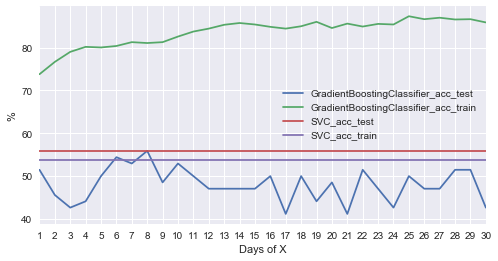

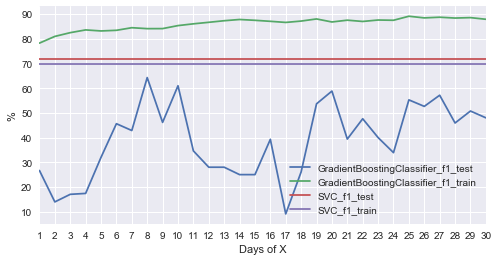

In [29]:
results_best          = score_day(X, y, clfs, size = Page_size/2,
     feature_days_max = 30,
     feature          = X_base)

----
## Improving Results

### Choosing the Best Model

**GradientBoostingClassifier** is the best model of the three models because of the **best F score, predicting time** and **good training time**. The algorithm is also suitable to handle the **mixed type of data** (heterogeneous features, Ref.: [`sklearn/modules/gradient-tree-boosting`](http://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting)).

The **Ensemble (Gradient Tree Boosting)** is based on the
**Tree**s which are composed of many feature-evaluation flows to prediction the income of every individual. For each individual, each tree starts from a specified feature-evaluation, e.g., age, to select the next branched feature-evaluations. After a sequence of sophisticated feature classification, the individual is classified to a predicted income class by a tree. 
The **Gradient** means: the feature selections, orders, and evaluation criteria of trees are tuned based on the prediction trend of the large data calculated by the calculus. 
The **Boosting** means: when tuning the trees, the false-predicted data will be weighted high to improve the weakness. 
The **Ensemble** means: The trees can vote as a team to perform better prediction than an individual. Each tree has different weaknesses and strengths because they grow and are tuned by arbitrary different data to try any better possibility.

### Implementation: Model Tuning

The best classifier is GradientBoostingClassifier with 75.00% f1-score and 8-day features to predict Close_Close_next_up 


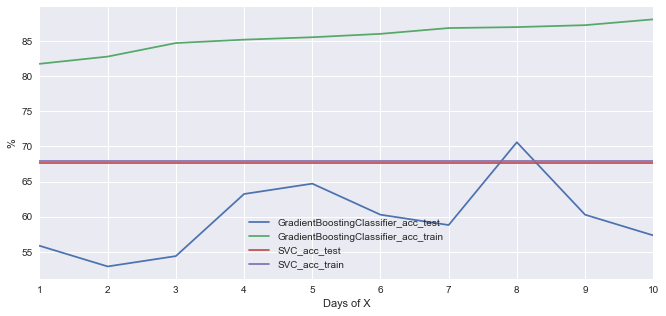

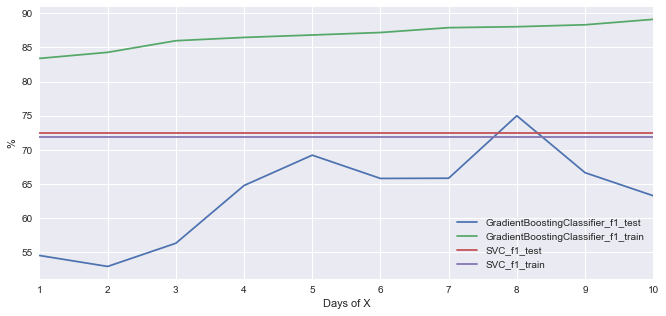

In [30]:
results_best          = score_day(X, y, clfs, size = Page_size*2/3,
     feature_days_max = 10,
     feature          = X_base
                      + X_vec
                      + X_up
                      + X_stat
                                 )

----
## Feature Importance

### Implementation - Extracting Feature Importance

In [31]:
def        feature_importances(  features, clf):
    df = pd.DataFrame         ({
          'Features'           : features,
                  'Importances':           clf .
           feature_importances_*100})    . sort_values(by =
                  'Importances', ascending = 0). reset_index(drop = 1).rename(index = lambda c: c + 1)
    df [          'Importances'] = df['Importances'].map(percent.format)
    return df

from sklearn.ensemble import GradientBoostingRegressor
def        feature_importances_GBR(X_train, y_train,     random_state = random_state, X_test = None, y_test = None):
    return feature_importances(    X_train.columns,
                               GradientBoostingRegressor(random_state = random_state).
                               fit(X_train, y_train))

def        feature_importances_display(  results, n = 5):
    display(concat([
           feature_importances        (  results['features']  ,
                                         results['clf'     ]) ,
           feature_importances_GBR    (**results['Xy'      ])], ['Classifier', 'Regressor']).head(n = n))

In [32]:
feature_importances_display(results_best)

Classifier                         Regressor            
               Features Importances              Features Importances
1       Close_Open_next      15.74%       Close_Open_next      13.55%
2  Close_Open_next_pre1       3.25%  Close_Open_next_pre1       3.24%
3           Volume_pre5       2.82%           Volume_pre1       2.60%
4           Volume_pre1       2.63%           Volume_pre5       2.54%
5                  RSI6       2.35%              WR6_pre3       2.42%

### Feature Relevance Observation

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics         import make_scorer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline        import Pipeline
# scaler     = MinMaxScaler()

def Grid   (clf, parameters,                     X = X, y = y, feature = X_all,  n_splits = 3, beta = beta , verbose = 1
                                                                      , feature_days = day_range_Max       ,       n = 5
                                                                      ,        label =    label , train_test_split = date_split):
    (X_train, X_test), (y_train, y_test) = Split(X[pre_feature(feature, feature_days)], y[label], train_test_split)
    display(concat([pd.DataFrame.from_dict(parameters, orient = 'index', dtype = object).T.fillna('').
                    rename(index = lambda c: c + 1)], ['Parameter Grid']))
#     pipe               = Pipeline(steps=[('scaler', scaler), ('clf', clf)])
#     grid               = GridSearchCV(clf, parameters, scoring = 'roc_auc'      (fbeta_score, beta = beta),
    grid               = GridSearchCV(clf, parameters, scoring = make_scorer    (fbeta_score,  beta = beta), verbose = verbose,
                                                       cv      = TimeSeriesSplit(n_splits = n_splits) .split(X_train))
    predict_train      = clf .fit(X_train, y_train)                 . predict(X_train)
    predict_test       = clf                                        . predict(X_test )
    estimator          = grid.fit(X_train, y_train).best_estimator_ 
    predict_train_best =                                 estimator  . predict(X_train)
    predict_test_best  =                                 estimator  . predict(X_test )

    display(concat([pd.DataFrame(OrderedDict([
      ('Train Accuracy'                  ,   [accuracy_score(y_train, predict_train                       )  ,
                                              accuracy_score(y_train, predict_train_best                  )]),
      ( 'Test Accuracy'                  ,   [accuracy_score(y_test , predict_test                        )  ,
                                              accuracy_score(y_test , predict_test_best                   )]),
      ('Train {}'.format(fbeta)          ,   [   fbeta_score(y_train, predict_train     ,      beta = beta)  ,
                                                 fbeta_score(y_train, predict_train_best,      beta = beta)]),
      ( 'Test {}'.format(fbeta)          ,   [   fbeta_score(y_test , predict_test      ,      beta = beta)  ,
                                                 fbeta_score(y_test , predict_test_best ,      beta = beta)]),
                                 ])).applymap(lambda s: '{:.1f}%'.format(100*s)),
         pd.concat([pd.DataFrame( clf. get_params(), index = [0])[parameters.keys()],
                    pd.DataFrame(grid.best_params_ , index = [1])[parameters.keys()]])])
                                             .rename(index = {0:   'Default Model',
                                                              1: 'Optimized Model'}))
    importances   = feature_importances(X_test.columns, grid.best_estimator_)
    display(concat([feature_importances(X_test.columns,           clf       ),
                            importances], ['Default', 'Optimized']).head(n = n))
    return grid,            importances

In [ ]:
feature          = results_best['feature']
feature          = X_base + X_vec + X_up + X_stat

parameters = OrderedDict([
    ('learning_rate'    ,
#       list(np.arange    (
# #         0.005           ,
#         0.01            ,
# #         0.011           ,
#         0.05            , # cur
# #         0.1             , # default
# #         0.11            ,
# #         0.2             ,
# #         0.21            ,
# #         0.001
#         0.01
# #         0.05
#                        ))+
    [
#         0.02            ,
        0.03            , # up
        0.04            , # cur
        0.05            , # up
#         0.1             , # default, ini
    ]                  ),
    ('n_estimators'     ,
#       range            (
#        20               ,
# #        50               ,
#       100 +1            , # default
# #       101               ,
#        10
#                        )+
    [
#        30               ,
#        40               ,
       50               , # cur
#        60               ,
      100               , # default, up
#       110               ,
    ]                  ),
    ('max_depth'        ,
#       range            (
#         2               ,
# #         3               , # default
# #         5               ,
# #         8 +1            ,
#        16               ,
#                        )+
    [
        2               , # cur
        3               , # default, up
#         8               , # ini
    ]                  ),
    ('min_samples_split',
#       range            (
# #         2               , # default
#         7               , # 0.5*len(y)
#        15 +1            , #     len(y)
#                        )+
    [
#         2               , # default
        7               , # 0.5*len(y), ini
        8               , # cur
        9               ,
#        15               , #     len(y)
    ]                  ),
    ('min_samples_leaf' ,
#       range            (
#         1               , # default
#         7 +1            , # 0.5*len(y)
#                        )+
    [
        1               , # default, cur
        2               , # up
#         3               , # ini
    ]                  ),
    ('max_features'     ,
#       range            (
#         6               ,
#        20               ,
#                        )+
    [
#         0.3             ,
        'sqrt'          , # ini, cur
#         0.4             ,
#         None            , # default
    ]                  ),
    ('subsample'        ,
#       list(np.arange    (
#         0.6             ,
#         1               ,
#         0.05
#                        ))+
    [
        0.7             , # low
        0.8             , # ini, cur
        0.9             , # up
#         1               , # default
    ]                  ),
    ]                  )
# parameters       = OrderedDict([(k, [v]) for k, v in GBC.get_params().items() if k in parameters.keys()])
# parameters       = [{'kernel': ['rbf'   ], 'C': [1, 10, 100, 1000], 'gamma': [1e-3, 1e-4]},
#                     {'kernel': ['linear'], 'C': [1, 10, 100, 1000]                       }]

grid, importances = Grid(
    GradientBoostingClassifier(random_state = random_state, warm_start = True),
#     svc,
    parameters, X, y,
    feature,
    feature_days = results_best['days'], n = 10
)

Parameter Grid                                                            \
   learning_rate n_estimators max_depth min_samples_split min_samples_leaf   
1           0.03           50         2                 7                1   
2           0.04          100         3                 8                2   
3           0.05                                        9                    

                          
  max_features subsample  
1         sqrt       0.7  
2                    0.8  
3                    0.9

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=1)]: Done 648 out of 648 | elapsed:  1.6min finished


,Train Accuracy,Test Accuracy,Train f1,Test f1,learning_rate,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features,subsample
Default Model,87.0%,70.6%,88.0%,75.0%,0.10,100,3,2,1,None,1.0
Optimized Model,71.2%,69.1%,75.4%,76.4%,0.04,50,2,8,1,sqrt,0.8


Default                         Optimized            
                Features Importances              Features Importances
1        Close_Open_next      15.74%       Close_Open_next      12.16%
2   Close_Open_next_pre1       3.25%    Close_Open_next_up       9.78%
3            Volume_pre5       2.82%                  RSI6       3.86%
4            Volume_pre1       2.63%   Open_Open_next_pre6       3.06%
5                   RSI6       2.35%             WR10_pre6       2.60%
6    Open_pre_Close_pre1       2.05%             WR10_pre3       2.39%
7              WR10_pre2       2.03%  Close_pre_Close_pre5       2.29%
8    Open_Open_next_pre7       1.83%            Open_Close       1.94%
9               WR6_pre3       1.74%           Volume_pre2       1.93%
10            RSI12_pre7       1.69%             WR10_pre2       1.91%

In [ ]:
feature_days_max =  14
features         = [
#                     'Open'              ,
#                     'High'              ,
#                     'Low'               ,
#                     'Close'             ,
#                     'Open_next'         ,
                    'Volume'            ,
                    'Open_pre_Close'    ,
                    'Open_pre_Close_up' ,
                    'Close_pre_Close'   ,
                    'Close_pre_Close_up',
                    'Open_Close'        ,
                    'Open_Close_up'     ,
                    'Open_Open_next'    ,
                    'Open_Open_next_up' ,
                    'Close_Open_next'   ,
                    'Close_Open_next_up',
                    'WR10'              ,
#                     'WR6'               ,
#                     'RSI12'             ,
                    'RSI6'              ,
#                     'MACD'              ,
#                     'C2M'               ,
#                     'Boll_u'            ,
#                     'Boll'              ,
#                     'Boll_l'            ,
                   ]
clf              = [
                    GBC, 
#                     GradientBoostingClassifier(random_state = random_state, **grid.best_params_),
                   ]
# display(concat([pd.DataFrame({k: v for k, v in grid.best_params_.items() if k in parameters.keys()},
#                              index = ['best'])], ['params']))

from tqdm      import tqdm
from itertools import combinations
results_best = {fbeta: 0}
for n in range(6, 1   +                    len(features)   ):
    for feature in tqdm(map(list, combinations(features, n))):
        cur                     = score_day   (output = 0,
            clfs                = clf,
            feature_days_max    =              feature_days_max,
            feature             =              feature)
        if  results_best[fbeta] < cur         [fbeta]:
            results_best        = cur
            print '{:.2f}% {} by {}-day {}'.format(100*cur[fbeta], fbeta, cur['days'], csv(feature))

  0%|                                                                                                                                                                                                     | 0/1716 [00:00<?, ?it/s]

59.74% f1 by 5-day Volume, Open_pre_Close, Open_pre_Close_up, Close_pre_Close, Close_pre_Close_up & Open_Close


  0%|                                                                                                                                                                                           | 1/1716 [00:08<4:03:31,  8.52s/it]

64.52% f1 by 1-day Volume, Open_pre_Close, Open_pre_Close_up, Close_pre_Close, Close_pre_Close_up & Open_Close_up


  0%|▏                                                                                                                                                                                          | 2/1716 [00:14<3:43:49,  7.84s/it]

65.82% f1 by 1-day Volume, Open_pre_Close, Open_pre_Close_up, Close_pre_Close, Close_pre_Close_up & Open_Open_next


  0%|▎                                                                                                                                                                                          | 3/1716 [00:21<3:37:30,  7.62s/it]

68.18% f1 by 1-day Volume, Open_pre_Close, Open_pre_Close_up, Close_pre_Close, Close_pre_Close_up & Open_Open_next_up


  0%|▍                                                                                                                                                                                          | 4/1716 [00:28<3:24:44,  7.18s/it]

76.19% f1 by 8-day Volume, Open_pre_Close, Open_pre_Close_up, Close_pre_Close, Close_pre_Close_up & Close_Open_next


  2%|██▊                                                                                                                                                                                       | 26/1716 [03:07<3:27:46,  7.38s/it]

77.11% f1 by 8-day Volume, Open_pre_Close, Open_pre_Close_up, Close_pre_Close, Open_Open_next_up & Close_Open_next


  2%|███▋                                                                                                                                                                                      | 34/1716 [04:05<3:25:45,  7.34s/it]

77.27% f1 by 5-day Volume, Open_pre_Close, Open_pre_Close_up, Close_pre_Close, Close_Open_next_up & RSI6


  3%|██████▌                                                                                                                                                                                   | 60/1716 [06:52<3:04:37,  6.69s/it]

In [ ]:
results_best         = score_day(    X, y, clfs,
    feature_days_max = 20,
    feature          = [
#                    'Open'              ,
#                    'High'              ,
#                    'Low'               ,
#                    'Close'             ,
#                    'Open_next'         ,
                   'Volume'            ,
                   'Open_pre_Close'    ,
#                    'Open_pre_Close_up' ,
#                    'Close_pre_Close'   ,
                   'Close_pre_Close_up',
#                    'Open_Close'        ,
                   'Open_Close_up'     ,
#                    'Open_Open_next'    ,
#                    'Open_Open_next_up' ,
                   'Close_Open_next'   ,
#                    'Close_Open_next_up',
                   'WR10'              ,
#                    'WR6'               ,
#                    'RSI12'             ,
#                    'RSI6'              ,
#                    'MACD'              ,
#                    'C2M'               ,
#                    'Boll_u'            ,
#                    'Boll'              ,
#                    'Boll_l'            ,
                        ])

In [ ]:
f = sns.barplot(results_best['features'],
                results_best['clf'     ].feature_importances_*100,
                ax  = plt.subplots(figsize = (Page_size, Page_size/2))[1]);
f.set_xticklabels(f.get_xticklabels(), rotation = 90)
f.set_ylabel   (                        'Feature Importances (%)');

### Final Model Evaluation

In [ ]:
labels          =  ['Close_next', 'Open_next']

from sklearn.metrics import           r2_score

data_train,       data_test = Split1(data_log[day_range_Max - 1:], date_split)
for label in labels:
    y_train_raw = data_train[[label]]
    y_test_raw  = data_test [[label]]
    scaler_y    =        MinMaxScaler().fit            (                                                  y_train_raw )
    regressor   =    LinearRegression().fit            (X_train[X_base], scaler_y.        transform(y_train_raw))
    predict     =          regressor   .       predict (X_test [X_base])
    predict_raw =                                                        scaler_y.inverse_transform(
                                               predict                                                   )
    regression  = y_test_raw.copy()
    regression[label +   '_Regression_Test'] = predict_raw
    classification = data_test[label.split('_')[0]] <= regression
    x           = label.split('_')[0]
    acc, f1     = clf_scores(data_test[                  x        ] <= regression.iloc[:, -1],
                             data_test['{}_{}_up'.format(x, label)]                          , beta)
    print              '{} Regression r2-Score: {:6.2f}%'                    .format (label, 100*
                                      r2_score(predict                       , scaler_y.        transform(y_test_raw )))
    print  '{} Up/Down Classification Accuracy Score by Regression: {:6.2f}%'.format (label, 100* acc)
    print  '{} Up/Down Classification       F1-Score by Regression: {:6.2f}%'.format (label, 100*  f1)
    ax = regression.plot( figsize = (Page_size, Page_size/2));
    ax .    set_ylabel  ('Price')
    plt.show()